In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoprice-dataset/test_dataset.parquet
/kaggle/input/autoprice-dataset/train_dataset.parquet
/kaggle/input/autoprice-dataset/sample_submission (6).csv


# Сиды

In [99]:
import numpy as np
import random
import os 

seed=42

os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
random.seed(seed)


# Импорты

In [100]:
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import matplotlib.pyplot as plt 


# TEST MODE

In [101]:
TEST_MODE=False

# Загрузка данных

In [102]:
train=pd.read_parquet('/kaggle/input/autoprice-dataset/train_dataset.parquet')
test=pd.read_parquet('/kaggle/input/autoprice-dataset/test_dataset.parquet')
sample=pd.read_csv('/kaggle/input/autoprice-dataset/sample_submission (6).csv')

#smth else?


In [103]:
id_test=test['ID']

# cat and num feats 

In [104]:
drop_nonsence=['ID']

In [105]:
train=train.drop(columns=drop_nonsence)
test=test.drop(columns=drop_nonsence)

In [106]:
cat_feats=train.select_dtypes(include=['object', 'string', 'category']).columns.tolist()
num_feats=train.drop(columns='price_TARGET').select_dtypes(include='number').columns.tolist()


# If TEST MODE

In [107]:
if TEST_MODE:
    train=train[:100]
else:
    train=train

# EDA

In [108]:
train.head()

,equipment,body_type,drive_type,engine_type,doors_number,color,pts,audiosistema,diski,electropodemniki,...,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult,price_TARGET
0,Базовая,Седан,Передний,Бензин,4,Синий,Дубликат,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],51000
1,Базовая,Универсал,Задний,Бензин,5,Бежевый,Оригинал,None,"14""",None,...,[None],[None],[None],[None],[None],[None],[Сигнализация],[None],[None],195000
2,None,Внедорожник,Полный,Гибрид,5,Чёрный,Электронный,None,None,None,...,"[Противотуманные, Омыватели фар, Адаптивное ос...","[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Задних сидений, Зеркал, Зад...","[Сиденья водителя, Задних сидений, Зеркал, Рул...","[Фронтальная для водителя, Коленные, Шторки, Б...","[Автопарковщик, Датчик дождя, Датчик света, Па...","[Сигнализация, Центральный замок, Иммобилайзер...","[Кожаный руль, Люк]","[Управление на руле, Атермальное остекление]",7251000
3,Titanium,Седан,Передний,Бензин,4,Серебряный,Оригинал,6 колонок,"16""",Передние и задние,...,[None],"[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Заднего стекла]",[None],"[Фронтальная для водителя, Коленные, Шторки, Б...","[Датчик дождя, Датчик света, Парктроник задний...","[Сигнализация, Центральный замок]",[Кожаный руль],[Управление на руле],1067000
4,Базовая,Седан,Передний,Бензин,4,Чёрный,Оригинал,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],54000


In [109]:
test.head()

,equipment,body_type,drive_type,engine_type,doors_number,color,pts,audiosistema,diski,electropodemniki,...,electroprivod_mult,fary_mult,multimedia_navigacia_mult,obogrev_mult,pamyat_nastroek_mult,podushki_bezopasnosti_mult,pomosh_pri_vozhdenii_mult,protivoygonnaya_sistema_mult,salon_mult,upravlenie_klimatom_mult
0,Базовая,Седан,Задний,Бензин,2,Жёлтый,None,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
1,Базовая,Хетчбэк,Передний,Бензин,3,Белый,None,None,None,None,...,[None],[None],[None],[None],[None],[None],[None],[None],[None],[None]
2,None,Внедорожник,Полный,Дизель,5,Синий,None,6 колонок,"19""",Передние и задние,...,[Зеркал],[None],"[Радио, AUX]","[Передних сидений, Задних сидений, Зеркал, Зад...",[None],"[Фронтальная для водителя, Боковые передние, Б...",[Парктроник задний],"[Сигнализация, Центральный замок]",[Кожаный руль],[None]
3,Sport,Седан,Передний,Бензин,4,Серебряный,Оригинал,8+ колонок,"17""",Передние и задние,...,"[Передних сидений, Зеркал, Складывания зеркал]","[Противотуманные, Омыватели фар, Адаптивное ос...","[CD привод, MP3, Радио, TV, Экран, Управление ...","[Передних сидений, Зеркал, Заднего стекла]",[None],"[Фронтальная для водителя, Коленные, Шторки, Б...","[Датчик дождя, Датчик света, Парктроник задний...","[Сигнализация, Центральный замок]",[Кожаный руль],"[Управление на руле, Атермальное остекление]"
4,Базовая,Хетчбэк,Передний,Бензин,3,Синий,None,None,None,Только передние,...,[None],[None],[None],"[Зеркал, Заднего стекла]",[None],[None],[Парктроник задний],"[Сигнализация, Центральный замок]",[Кожаный руль],[None]


In [110]:
sample.head()

,ID,target
0,8,100000
1,26,100000
2,33,100000
3,52,100000
4,119,100000


In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   equipment                     55572 non-null  object 
 1   body_type                     70000 non-null  object 
 2   drive_type                    70000 non-null  object 
 3   engine_type                   70000 non-null  object 
 4   doors_number                  70000 non-null  int64  
 5   color                         70000 non-null  object 
 6   pts                           65026 non-null  object 
 7   audiosistema                  25824 non-null  object 
 8   diski                         32190 non-null  object 
 9   electropodemniki              36271 non-null  object 
 10  fary                          22652 non-null  object 
 11  salon                         34500 non-null  object 
 12  upravlenie_klimatom           30345 non-null  object 
 13  u

In [112]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   equipment                     19468 non-null  object 
 1   body_type                     25000 non-null  object 
 2   drive_type                    25000 non-null  object 
 3   engine_type                   25000 non-null  object 
 4   doors_number                  25000 non-null  int64  
 5   color                         25000 non-null  object 
 6   pts                           23047 non-null  object 
 7   audiosistema                  8805 non-null   object 
 8   diski                         13177 non-null  object 
 9   electropodemniki              9301 non-null   object 
 10  fary                          9057 non-null   object 
 11  salon                         12968 non-null  object 
 12  upravlenie_klimatom           9644 non-null   object 
 13  u

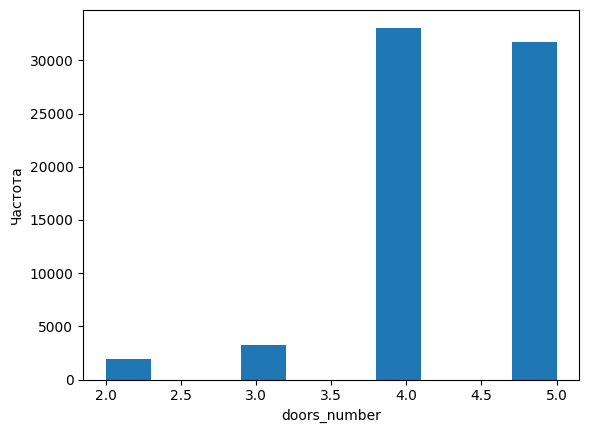

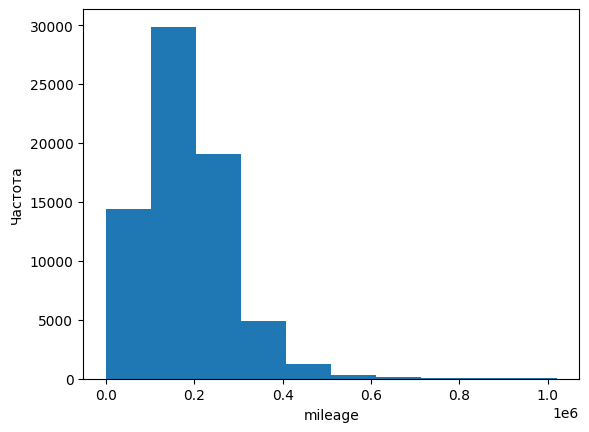

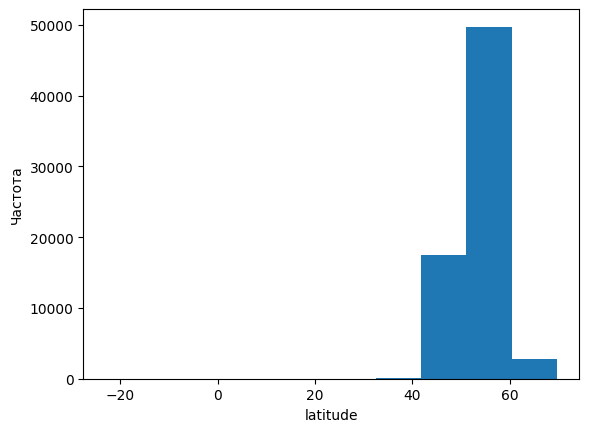

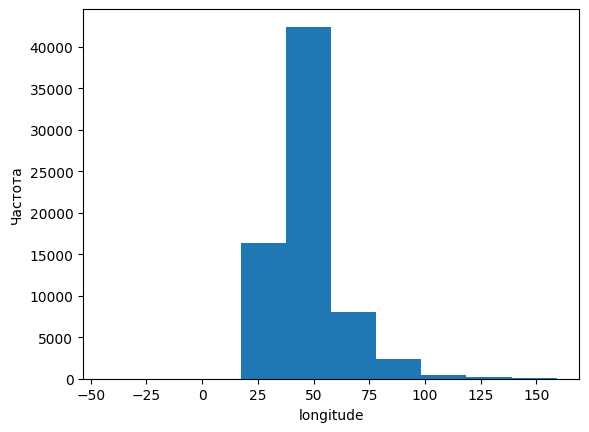

In [113]:
for col in num_feats:
    plt.figure()
    plt.hist(train[col])
    
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

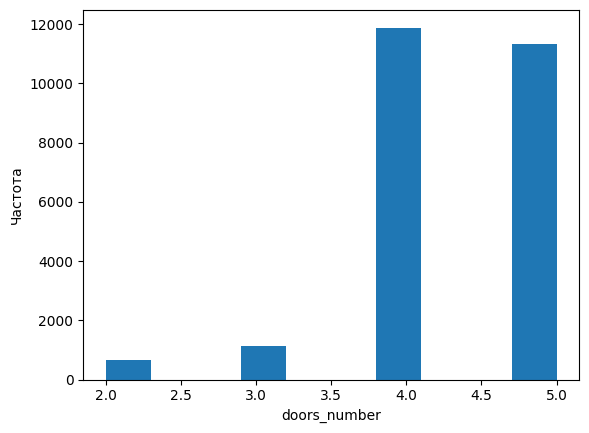

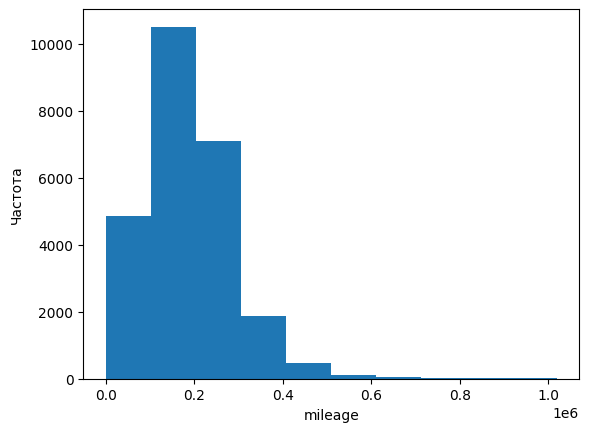

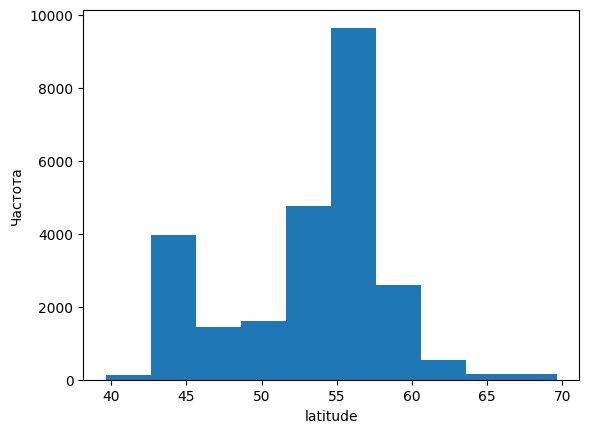

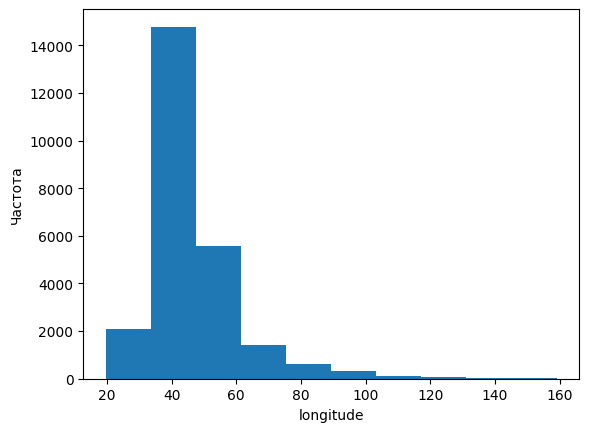

In [114]:
for col in num_feats:
    plt.figure()
    plt.hist(test[col])
    
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

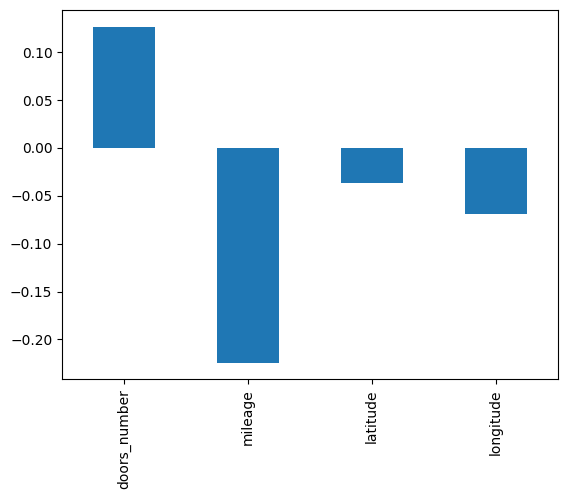

In [115]:
#for col in num_feats:
correlation=train[num_feats].corrwith(train['price_TARGET'])
plt.figure()
correlation.plot(kind='bar')
plt.show()

In [116]:
#for col in cat_feats:
#    counts=train[col].value_counts()
#    plt.figure()
 #   counts.plot(kind='bar')
#    plt.xlabel(col)
#    plt.ylabel('Частота')

In [117]:
#for col in cat_feats:
#    cat_crt=pd.crosstab(train['col'], train['price_TARGET'], normalize='columns')*100
#    ax=cat_crt.plot(kind='bar')
#    ax.set_xlabel(col)
#    ax.set_ylabel('%')
#    plt.show()

# Cleaning???

# Feature engineering

In [118]:
num_feats

['doors_number', 'mileage', 'latitude', 'longitude']

In [119]:
cat_feats

['equipment',
 'body_type',
 'drive_type',
 'engine_type',
 'color',
 'pts',
 'audiosistema',
 'diski',
 'electropodemniki',
 'fary',
 'salon',
 'upravlenie_klimatom',
 'usilitel_rul',
 'steering_wheel',
 'crashes_count',
 'owners_count',
 'aktivnaya_bezopasnost_mult',
 'audiosistema_mult',
 'shini_i_diski_mult',
 'electroprivod_mult',
 'fary_mult',
 'multimedia_navigacia_mult',
 'obogrev_mult',
 'pamyat_nastroek_mult',
 'podushki_bezopasnosti_mult',
 'pomosh_pri_vozhdenii_mult',
 'protivoygonnaya_sistema_mult',
 'salon_mult',
 'upravlenie_klimatom_mult']

In [120]:
# 'doors_number', 'mileage', 'latitude', 'longitude'

In [121]:
import re
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ---------- helpers: normalize russian text tokens ----------
def _norm_token(s: str) -> str:
    s = s.lower().strip()
    s = s.replace('ё', 'е')
    s = re.sub(r'[\[\]\(\)"“”«»:+*/\\|]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip('.,; ')
    # короткие стоп-слова и «служебные» хвосты
    stop = {'и','для','из','с','в','на','руля','сидений','сиденья','стекла','стекло','передних','задних'}
    toks = [t for t in s.split() if t and t not in stop]
    return '_'.join(toks)

def _parse_list_field(x):
    """Возвращает список токенов для значения-строки в формате [A, B] / 'None' / NaN"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    s = str(x).strip()
    if s == '' or s.lower() in {'none','nan','[none]'}:
        return []
    # выковыриваем содержимое из скобок, если есть
    m = re.match(r'^\s*\[(.*)\]\s*$', s)
    if m:
        s = m.group(1)
    # делим по запятым/точкам с запятой
    raw = [t.strip() for t in re.split(r'[;,]', s) if t.strip()]
    # если разделителей не было: оставим один «как есть»
    if not raw and s:
        raw = [s]
    toks = [_norm_token(t) for t in raw]
    toks = [t for t in toks if t and t not in {'none','-'}]
    return toks

# ---------- detect multivalue columns ----------
def detect_mult_cols(df: pd.DataFrame) -> list[str]:
    cand = []
    for c in df.columns:
        if df[c].dtype == object or pd.api.types.is_string_dtype(df[c]):
            sample = df[c].astype(str).head(200).tolist()
            share_brackets = np.mean([1 if s.strip().startswith('[') and s.strip().endswith(']') else 0 for s in sample])
            if c.endswith('_mult') or share_brackets > 0.25:
                cand.append(c)
    return cand

# ---------- vocab per column (top-K tokens) ----------
def fit_token_vocab(train: pd.DataFrame, mult_cols: list[str], top_k: int = 30, min_df: int = 15) -> dict[str, list[str]]:
    vocab = {}
    for c in mult_cols:
        cnt = Counter()
        for x in train[c].values:
            cnt.update(set(_parse_list_field(x)))   # set → считаем по документам, не по повторам
        # частотный фильтр
        toks = [t for t, n in cnt.items() if n >= min_df]
        toks = sorted(toks, key=lambda t: (-cnt[t], t))[:top_k]
        vocab[c] = toks
    return vocab

def transform_mult(df: pd.DataFrame, vocab: dict[str, list[str]]) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for c, toks in vocab.items():
        parsed = df[c].map(_parse_list_field)
        out[f'{c}__count'] = parsed.map(len).astype('Int16')
        for t in toks:
            out[f'{c}__has_{t}'] = parsed.map(lambda lst: int(t in lst)).astype('Int8')
    return out

# ---------- specialized single-field parsers ----------
def parse_audio_speakers(s) -> float:
    # "6 колонок" → 6
    if pd.isna(s): return np.nan
    m = re.search(r'(\d+)', str(s))
    return float(m.group(1)) if m else np.nan

def parse_rim_inch(s) -> float:
    # '16"' → 16 ; '14"' → 14
    if pd.isna(s): return np.nan
    m = re.search(r'(\d{2})\s*["ʺ″]?$', str(s).strip())
    return float(m.group(1)) if m else np.nan

def parse_power_windows(s) -> tuple[int,int]:
    # electropodemniki: "Передние и задние" / "Передние" / "Задние"
    if pd.isna(s): return (0,0)
    st = str(s).lower()
    fr = int('перед' in st)
    rr = int('задн'  in st)
    if 'и' in st and fr and rr:
        return (1,1)
    return (fr, rr)

def canon_color(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    st = st.replace('ё','е')
    mapping = [
        ('черн', 'black'), ('бел', 'white'), ('сереб', 'silver'),
        ('сер', 'gray'), ('син', 'blue'), ('голуб', 'blue'),
        ('красн', 'red'), ('борд', 'red'), ('фиолет', 'purple'),
        ('зелен', 'green'), ('беж', 'beige'), ('корич', 'brown'),
        ('бронз', 'brown'), ('желт', 'yellow'), ('оранж', 'orange'),
        ('серо', 'gray')
    ]
    for key, val in mapping:
        if key in st: return val
    return 'other'

def canon_engine(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    if 'гибрид' in st or 'hybrid' in st: return 'hybrid'
    if 'диз' in st or 'diesel' in st:    return 'diesel'
    if 'элект' in st or 'ev' in st:      return 'electric'
    if 'газ' in st or 'lpg' in st or 'cng' in st: return 'gas'
    return 'petrol'

def canon_drive(s) -> str:
    if pd.isna(s): return 'unk'
    st = str(s).lower()
    if 'пол' in st or 'awd' in st or '4wd' in st: return 'awd'
    if 'перед' in st or 'fwd' in st: return 'fwd'
    if 'задн' in st or 'rwd' in st: return 'rwd'
    return 'unk'

def pts_flag(s) -> int:
    if pd.isna(s): return 0
    st = str(s).lower()
    return int('дублик' in st or 'duplicate' in st or 'электрон' in st)

def trim_is_base(s) -> int:
    if pd.isna(s): return 0
    st = str(s).lower()
    return int('базов' in st or 'base' in st or st.strip() in {'none','стандарт'})

# ---------- main builder ----------
def build_features(train: pd.DataFrame, test: pd.DataFrame, top_k=25, min_df=15):
    tr, te = train.copy(), test.copy()

    # 1) multivalue columns
    mult_cols = detect_mult_cols(tr)
    vocab = fit_token_vocab(tr, mult_cols, top_k=top_k, min_df=min_df)
    tr_mult = transform_mult(tr, vocab)
    te_mult = transform_mult(te, vocab)

    # 2) specialized single fields (robust, low-card)
    if 'audiosistema' in tr.columns:
        tr_mult['audio_speakers'] = tr['audiosistema'].map(parse_audio_speakers).astype('float32')
        te_mult['audio_speakers'] = te['audiosistema'].map(parse_audio_speakers).astype('float32')

    if 'diski' in tr.columns:
        tr_mult['rim_inch'] = tr['diski'].map(parse_rim_inch).astype('float32')
        te_mult['rim_inch'] = te['diski'].map(parse_rim_inch).astype('float32')

    if 'electropodemniki' in tr.columns:
        fr_tr, rr_tr = zip(*tr['electropodemniki'].map(parse_power_windows))
        fr_te, rr_te = zip(*te['electropodemniki'].map(parse_power_windows))

    # делаем сразу pandas Series с nullable Int8
        tr_mult['power_windows_front'] = pd.Series(fr_tr, index=tr.index, dtype='Int8')
        tr_mult['power_windows_rear']  = pd.Series(rr_tr, index=tr.index, dtype='Int8')
        te_mult['power_windows_front'] = pd.Series(fr_te, index=te.index, dtype='Int8')
        te_mult['power_windows_rear']  = pd.Series(rr_te, index=te.index, dtype='Int8')


    # 3) normalized categoricals (safe, compact)
    for col, fn in [
        ('color', canon_color),
        ('engine_type', canon_engine),
        ('drive_type', canon_drive),
    ]:
        if col in tr.columns:
            tr_mult[col+'_canon'] = tr[col].map(fn).astype('category')
            te_mult[col+'_canon'] = te[col].map(fn).astype('category')

    if 'pts' in tr.columns:
        tr_mult['pts_is_duplicate'] = tr['pts'].map(pts_flag).astype('Int8')
        te_mult['pts_is_duplicate'] = te['pts'].map(pts_flag).astype('Int8')

    if 'equipment' in tr.columns:
        tr_mult['trim_is_base']   = tr['equipment'].map(trim_is_base).astype('Int8')
        te_mult['trim_is_base']   = te['equipment'].map(trim_is_base).astype('Int8')
        tr_mult['trim_len_chars'] = tr['equipment'].fillna('').astype(str).str.len().astype('Int16')
        te_mult['trim_len_chars'] = te['equipment'].fillna('').astype(str).str.len().astype('Int16')

    # 4) merge back (НЕ трогаем исходные столбцы — CatBoost сам переварит категории)
    train_fe = pd.concat([tr, tr_mult], axis=1)
    test_fe  = pd.concat([te, te_mult], axis=1)

    # NaN/inf cleanup
    num_cols_tr = train_fe.select_dtypes(include=[np.number]).columns
    num_cols_te = test_fe.select_dtypes(include=[np.number]).columns

    train_fe[num_cols_tr] = train_fe[num_cols_tr].replace([np.inf, -np.inf], np.nan)
    test_fe[num_cols_te]  = test_fe[num_cols_te].replace([np.inf, -np.inf], np.nan)
    return train_fe, test_fe


    #return train_fe, test_fe


In [122]:
import numpy as np, pandas as pd, re

def add_simple_gems(train: pd.DataFrame, test: pd.DataFrame):
    tr = train.copy(); te = test.copy()

    def _col(df, pat):
        r = re.compile(pat, re.I)
        for c in df.columns:
            if r.search(c): return c
        return None

    # ---- 1) Возраст/пробег (очень базовые, но сильные) ----
    year_col = _col(tr, r'(^|_)(year|prod|release)')
    if year_col is not None:
        cur_year = pd.Timestamp('today').year
        tr['age'] = (cur_year - pd.to_numeric(tr[year_col], errors='coerce')).astype('float32')
        te['age'] = (cur_year - pd.to_numeric(te[year_col], errors='coerce')).astype('float32')
        # мягкие бины возраста (инт) — модель любит
        tr['age_bin'] = pd.cut(tr['age'], bins=[-1,3,6,9,12,15,20,30,60], labels=False).astype('Int8')
        te['age_bin'] = pd.cut(te['age'], bins=[-1,3,6,9,12,15,20,30,60], labels=False).astype('Int8')

    if 'mileage' in tr.columns:
        tr['mileage_log1p'] = np.log1p(tr['mileage'].clip(lower=0)).astype('float32')
        te['mileage_log1p'] = np.log1p(te['mileage'].clip(lower=0)).astype('float32')
        tr['mileage_sqrt']  = np.sqrt(tr['mileage'].clip(lower=0)).astype('float32')
        te['mileage_sqrt']  = np.sqrt(te['mileage'].clip(lower=0)).astype('float32')
        # очень простой дискрет: шаг 10k
        tr['mileage_10k_bin'] = (tr['mileage'].clip(lower=0) // 10_000).astype('Int16')
        te['mileage_10k_bin'] = (te['mileage'].clip(lower=0) // 10_000).astype('Int16')
        if 'age' in tr.columns:
            eps=0.5
            tr['mpy'] = (tr['mileage']/(tr['age']+eps)).astype('float32')         # mileage per year
            te['mpy'] = (te['mileage']/(te['age']+eps)).astype('float32')
            # очень простые флаги: «аномально много/мало для возраста»
            tr['mpy_high'] = (tr['mpy']>25_000).astype('Int8')
            te['mpy_high'] = (te['mpy']>25_000).astype('Int8')
            tr['mpy_low']  = (tr['mpy']<7_000).astype('Int8')
            te['mpy_low']  = (te['mpy']<7_000).astype('Int8')

    # ---- 2) Двигатель/мощность/простые бины ----
    hp_col  = _col(tr, r'(^|_)(hp|power)')
    eng_col = _col(tr, r'(^|_)engine(_l|_size|_capacity|_disp)?')
    if hp_col is not None:
        tr['hp_bin50'] = (pd.to_numeric(tr[hp_col], errors='coerce') // 50).astype('Int16')
        te['hp_bin50'] = (pd.to_numeric(te[hp_col], errors='coerce') // 50).astype('Int16')
    if eng_col is not None:
        e_tr = pd.to_numeric(tr[eng_col], errors='coerce')
        e_te = pd.to_numeric(te[eng_col], errors='coerce')
        tr['eng_bin02'] = (np.floor(e_tr/0.2)).astype('Int16')   # шаг 0.2 л
        te['eng_bin02'] = (np.floor(e_te/0.2)).astype('Int16')
    if hp_col is not None and eng_col is not None:
        hp_tr = pd.to_numeric(tr[hp_col], errors='coerce')
        hp_te = pd.to_numeric(te[hp_col], errors='coerce')
        en_tr = pd.to_numeric(tr[eng_col], errors='coerce').replace(0,np.nan)
        en_te = pd.to_numeric(te[eng_col], errors='coerce').replace(0,np.nan)
        tr['hp_per_l'] = (hp_tr/en_tr).astype('float32')
        te['hp_per_l'] = (hp_te/en_te).astype('float32')
        # простое взаимодействие: «возраст × удельная мощность»
        if 'age' in tr.columns:
            tr['age_x_hppl'] = (tr['age'] * tr['hp_per_l']).astype('float32')
            te['age_x_hppl'] = (te['age'] * te['hp_per_l']).astype('float32')

    # ---- 3) Передача/привод — только лёгкие флаги по подстрокам ----
    def _flag(s, keys):
        if pd.isna(s): return 0
        st=str(s).lower()
        return int(any(k in st for k in keys))

    tr_cols = [c for c in ['transmission','kpp'] if c in tr.columns]
    if tr_cols:
        col = tr_cols[0]
        for name,keys in [
            ('is_at',  ['авто','at','auto']),
            ('is_cvt', ['вариатор','cvt']),
            ('is_dct', ['роб','dct','dsG','robot']),
            ('is_mt',  ['руч','mt','manual']),
        ]:
            tr[name] = tr[col].map(lambda x:_flag(x,keys)).astype('Int8')
            te[name] = te[col].map(lambda x:_flag(x,keys)).astype('Int8')

    drv_col = _col(tr, r'(drive|privod)')
    if drv_col is not None:
        for name,keys in [
            ('is_awd', ['пол','awd','4wd','4x4']),
            ('is_fwd', ['перед','fwd']),
            ('is_rwd', ['задн','rwd']),
        ]:
            tr[name] = tr[drv_col].map(lambda x:_flag(x,keys)).astype('Int8')
            te[name] = te[drv_col].map(lambda x:_flag(x,keys)).astype('Int8')

    # ---- 4) Цвет — компактный one-hot на самые массовые ----
    col_col = _col(tr, r'(^|_)color')
    if col_col is not None:
        def _canon_color(s):
            if pd.isna(s): return 'unk'
            st=str(s).lower().replace('ё','е')
            mapping=[('черн','black'),('бел','white'),('сереб','silver'),('сер','gray'),
                     ('син','blue'),('голуб','blue'),('красн','red'),('зелен','green'),
                     ('корич','brown'),('беж','beige'),('оранж','orange'),('желт','yellow')]
            for k,v in mapping:
                if k in st: return v
            return 'other'
        tr['color_canon'] = tr[col_col].map(_canon_color).astype('category')
        te['color_canon'] = te[col_col].map(_canon_color).astype('category')
        # простой бинарный «тёмный/светлый»
        dark = {'black','gray','brown'}
        light= {'white','silver','beige'}
        tr['is_dark']  = tr['color_canon'].isin(dark).astype('Int8')
        te['is_dark']  = te['color_canon'].isin(dark).astype('Int8')
        tr['is_light'] = tr['color_canon'].isin(light).astype('Int8')
        te['is_light'] = te['color_canon'].isin(light).astype('Int8')

    # ---- 5) Brand/Model простейшие счётчики (unsupervised, без таргета) ----
    brand_col = _col(tr, r'(^|_)(brand|marka|make)')
    model_col = _col(tr, r'(^|_)(model|modif|generation)')
    if brand_col is not None:
        all_b = pd.concat([tr[brand_col], te[brand_col]], axis=0).astype(str)
        b_cnt = all_b.value_counts()
        tr['brand_freq'] = tr[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')
        te['brand_freq'] = te[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')
    if brand_col is not None and model_col is not None:
        all_bm = pd.concat([tr[[brand_col,model_col]], te[[brand_col,model_col]]], axis=0).astype(str)
        bm_key = all_bm[brand_col].str.cat(all_bm[model_col], sep='|')
        bm_cnt = bm_key.value_counts()
        tr['bm_freq'] = tr[brand_col].astype(str).str.cat(tr[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')
        te['bm_freq'] = te[brand_col].astype(str).str.cat(te[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')
        # редкость как лог-инверсия частоты (простая и сильная)
        tr['bm_rarity'] = np.log1p(1_000_000/(1+tr['bm_freq'])).astype('float32')
        te['bm_rarity'] = np.log1p(1_000_000/(1+te['bm_freq'])).astype('float32')

    # ---- 6) Equipment — только длины, без токенизации ----
    if 'equipment' in tr.columns:
        tr['equipment_len']  = tr['equipment'].fillna('').astype(str).str.len().astype('Int16')
        te['equipment_len']  = te['equipment'].fillna('').astype(str).str.len().astype('Int16')
        tr['equipment_wc']   = tr['equipment'].fillna('').astype(str).str.split().map(len).astype('Int16')
        te['equipment_wc']   = te['equipment'].fillna('').astype(str).str.split().map(len).astype('Int16')

    # ---- 7) Простые флаги по «праворульности» и числу владельцев (если есть) ----
    wheel_col = _col(tr, r'(wheel|rud)')
    if wheel_col is not None:
        tr['is_rhd'] = tr[wheel_col].astype(str).str.lower().str.contains('прав').astype('Int8')
        te['is_rhd'] = te[wheel_col].astype(str).str.lower().str.contains('прав').astype('Int8')

    owners_col = _col(tr, r'(owners?|vladel|owner_count)')
    if owners_col is not None:
        oc_tr = pd.to_numeric(tr[owners_col], errors='coerce')
        oc_te = pd.to_numeric(te[owners_col], errors='coerce')
        tr['owners_bin'] = oc_tr.clip(lower=0, upper=5).astype('Int8')
        te['owners_bin'] = oc_te.clip(lower=0, upper=5).astype('Int8')

    # ---- 8) Миссы как сигнал ----
    for c in ['mileage', hp_col, eng_col, year_col]:
        if c is None: continue
        miss = f'{c}_isna'
        tr[miss] = tr[c].isna().astype('Int8')
        te[miss] = te[c].isna().astype('Int8')

    # ---- 9) Крошечные интеракции (реально простые) ----
    if 'age_bin' in tr.columns and 'is_at' in tr.columns:
        tr['young_auto'] = ((tr['age_bin']<=2) & (tr['is_at']==1)).astype('Int8')
        te['young_auto'] = ((te['age_bin']<=2) & (te['is_at']==1)).astype('Int8')
    if 'mpy' in tr.columns and 'bm_rarity' in tr.columns:
        tr['rare_x_mpy'] = (np.log1p(tr['bm_rarity']) * np.log1p(tr['mpy'].clip(lower=0))).astype('float32')
        te['rare_x_mpy'] = (np.log1p(te['bm_rarity']) * np.log1p(te['mpy'].clip(lower=0))).astype('float32')

    return tr, te


In [123]:
import numpy as np, pandas as pd, re
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from math import radians, cos, sin, asin, sqrt

# -------- helpers --------
def _col_exists(df, name_like):
    pat = re.compile(name_like, re.I)
    for c in df.columns:
        if pat.search(c): return c
    return None

def _safe_dt(s):
    return pd.to_datetime(s, errors='coerce', utc=True).dt.tz_localize(None)

def _haversine(lat1, lon1, lat2, lon2):
    # расстояние в км
    R = 6371.0
    dlat = radians(lat2 - lat1); dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*asin(sqrt(a))

def _cap(s, lo=None, hi=None):
    x = s.copy()
    if lo is not None: x = np.maximum(x, lo)
    if hi is not None: x = np.minimum(x, hi)
    return x

def _is_turbo_from_text(row, cols):
    txt = " ".join(str(row[c]).lower() for c in cols if c in row and pd.notna(row[c]))
    return int(any(k in txt for k in ['турбо','turbo','t-gdi','tsi','tce','biturbo']))

def _canon_from(col, mapping):
    def f(x):
        if pd.isna(x): return 'unk'
        s = str(x).lower()
        for key,val in mapping:
            if key in s: return val
        return 'other' if 'body' in col else 'unk'
    return f

def _idf_stats(series, min_df=10):
    # простая IDF по токенам списка/строки equipment
    def _tokens(x):
        if pd.isna(x): return []
        s = str(x).lower()
        s = s.replace('ё','е')
        s = re.sub(r'[\[\]\(\)"“”«»:+*/\\|]', ' ', s)
        s = re.sub(r'[,;]', ' ', s)
        toks = [t for t in s.split() if 2 <= len(t) <= 25]
        return list(set(toks))
    docs = series.fillna('').astype(str).tolist()
    N = len(docs)
    df = {}
    for s in docs:
        for t in set(_tokens(s)):
            df[t] = df.get(t, 0) + 1
    idf = {t: np.log((N + 1)/(n + 1)) + 1.0 for t, n in df.items() if n >= min_df}
    return idf

def _equip_idf_agg(series, idf):
    def _score(x):
        if pd.isna(x): return (0.0, 0.0, 0.0, 0)  # sum, mean, max, count
        s = str(x).lower()
        s = re.sub(r'[\[\]\(\)"“”«»:+*/\\|,;]', ' ', s)
        toks = list(set([t for t in s.split() if t in idf]))
        if not toks: return (0.0, 0.0, 0.0, 0)
        vals = [idf[t] for t in toks]
        return (float(np.sum(vals)), float(np.mean(vals)), float(np.max(vals)), len(vals))
    agg = series.map(_score)
    return (
        agg.map(lambda z: z[0]).astype('float32'),
        agg.map(lambda z: z[1]).astype('float32'),
        agg.map(lambda z: z[2]).astype('float32'),
        agg.map(lambda z: z[3]).astype('Int16'),
    )

def _oof_target_encode(df_train, df_test, y_log, colgroup, seed=42, n_splits=5, alpha=50.0):
    """
    OOF сглаженный target encoding для среднелога цены.
    df_train: DataFrame с признаками
    df_test : DataFrame с признаками теста
    y_log   : Series (index совпадает с df_train.index)
    colgroup: список колонок для группировки
    """
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    tr_enc = pd.Series(index=df_train.index, dtype='float32')
    global_mean = float(np.mean(y_log.values))

    def group_stats(idx):
        # собираем временную таблицу из ключей и таргета
        tmp = df_train.iloc[idx][colgroup].copy()
        tmp['_ylog_'] = y_log.iloc[idx].values
        g = tmp.groupby(colgroup)['_ylog_'].agg(['count', 'sum'])
        g = g.rename(columns={'count': 'cnt', 'sum': 'sum'})
        return g

    for tr_idx, va_idx in kf.split(df_train):
        gstat = group_stats(tr_idx)
        gstat['enc'] = (gstat['sum'] + alpha * global_mean) / (gstat['cnt'] + alpha)

        key_va = df_train.iloc[va_idx][colgroup]
        enc_va = key_va.merge(gstat[['enc']], left_on=colgroup, right_index=True, how='left')['enc']
        tr_enc.iloc[va_idx] = enc_va.fillna(global_mean).astype('float32').values

    # на тест применяем статистику по всему train
    gstat_full = group_stats(np.arange(len(df_train)))
    gstat_full['enc'] = (gstat_full['sum'] + alpha * global_mean) / (gstat_full['cnt'] + alpha)

    enc_te = df_test[colgroup].merge(gstat_full[['enc']], left_on=colgroup, right_index=True, how='left')['enc']
    enc_te = enc_te.fillna(global_mean).astype('float32').values

    name = f"te__{'__'.join(colgroup)}"
    return tr_enc.rename(name), pd.Series(enc_te, index=df_test.index, name=name)


def add_golden_features(train: pd.DataFrame, test: pd.DataFrame, y_col='price_TARGET', seed=42):
    tr, te = train.copy(), test.copy()

    # ---------- базовые численные ----------
    y = tr[y_col].astype(float).values
    y_log = pd.Series(np.log1p(y), index=tr.index, name='y_log')

    # year -> age
    year_col = _col_exists(tr, r'(^|_)year|production')
    if year_col is not None:
        year = pd.to_numeric(tr[year_col], errors='coerce')
        age = (pd.Timestamp('today').year - year).astype('float32')
        tr['age'] = age
        te['age'] = (pd.Timestamp('today').year - pd.to_numeric(te[year_col], errors='coerce')).astype('float32')
        tr['age_cap'] = _cap(tr['age'], lo=0, hi=30).astype('float32')
        te['age_cap'] = _cap(te['age'], lo=0, hi=30).astype('float32')
        tr['year_bin'] = pd.cut(year, bins=[1900,2005,2010,2015,2018,2021,2026], labels=False).astype('Int8')
        te['year_bin'] = pd.cut(pd.to_numeric(te[year_col], errors='coerce'),
                                bins=[1900,2005,2010,2015,2018,2021,2026], labels=False).astype('Int8')

    # mileage features
    if 'mileage' in tr.columns:
        tr['mileage_log1p'] = np.log1p(tr['mileage'].clip(lower=0)).astype('float32')
        te['mileage_log1p'] = np.log1p(te['mileage'].clip(lower=0)).astype('float32')
        if 'age_cap' in tr.columns:
            eps = 0.5
            tr['mileage_per_year'] = (tr['mileage'] / (tr['age'] + eps)).astype('float32')
            te['mileage_per_year'] = (te['mileage'] / (te['age'] + eps)).astype('float32')
            tr['mileage_per_year_cap'] = _cap(tr['mileage_per_year'], hi=100_000).astype('float32')
            te['mileage_per_year_cap'] = _cap(te['mileage_per_year'], hi=100_000).astype('float32')
            tr['age_x_mileage'] = (tr['age_cap'] * tr['mileage_log1p']).astype('float32')
            te['age_x_mileage'] = (te['age_cap'] * te['mileage_log1p']).astype('float32')

    # engine/hp features
    hp_col = _col_exists(tr, r'(^|_)hp|power')
    eng_col = _col_exists(tr, r'engine(_l|_size|_capacity|_displacement)?')
    if hp_col and eng_col:
        tr['hp_per_l'] = (pd.to_numeric(tr[hp_col], errors='coerce') /
                          pd.to_numeric(tr[eng_col], errors='coerce').replace(0, np.nan)).astype('float32')
        te['hp_per_l'] = (pd.to_numeric(te[hp_col], errors='coerce') /
                          pd.to_numeric(te[eng_col], errors='coerce').replace(0, np.nan)).astype('float32')
    # is_turbo
    turbo_cols = [c for c in ['engine', 'engine_type', 'modification', 'equipment'] if c in tr.columns]
    if turbo_cols:
        tr['is_turbo'] = tr.apply(lambda r: _is_turbo_from_text(r, turbo_cols), axis=1).astype('Int8')
        te['is_turbo'] = te.apply(lambda r: _is_turbo_from_text(r, turbo_cols), axis=1).astype('Int8')
        if 'hp_per_l' in tr.columns:
            tr['hppl_x_turbo'] = (tr['hp_per_l'] * (tr['is_turbo']+1)).astype('float32')
            te['hppl_x_turbo'] = (te['hp_per_l'] * (te['is_turbo']+1)).astype('float32')

    # transmission/body canon (очень лёгкие маппинги)
    if 'transmission' in tr.columns:
        mapping = [('авто','at'),('роб','dct'),('вариатор','cvt'),('руч','mt')]
        tr['transmission_canon'] = tr['transmission'].map(_canon_from('transmission', mapping)).astype('category')
        te['transmission_canon'] = te['transmission'].map(_canon_from('transmission', mapping)).astype('category')
    if _col_exists(tr, r'body|kuzov'):
        bc = _col_exists(tr, r'body|kuzov')
        mapping = [('седан','sedan'),('хэтч','hatch'),('универ','wagon'),('внедор','suv'),
                   ('кросс','suv'),('купе','coupe'),('минивэн','mpv'),('лифтбэк','liftback'),('пикап','pickup')]
        tr['body_canon'] = tr[bc].map(_canon_from('body', mapping)).astype('category')
        te['body_canon'] = te[bc].map(_canon_from('body', mapping)).astype('category')

    # ---------- гео ----------
    if {'latitude','longitude'}.issubset(tr.columns):
        for km, suf in [(1,'1km'), (5,'5km')]:
            tr[f'lat_{suf}'] = (tr['latitude'].round(3 if km==1 else 2)).astype('float32')
            tr[f'lon_{suf}'] = (tr['longitude'].round(3 if km==1 else 2)).astype('float32')
            te[f'lat_{suf}'] = (te['latitude'].round(3 if km==1 else 2)).astype('float32')
            te[f'lon_{suf}'] = (te['longitude'].round(3 if km==1 else 2)).astype('float32')

        # дистанции до крупных городов
        cities = {
            'msk': (55.7558, 37.6176),
            'spb': (59.9311, 30.3609),
            'ekb': (56.8380, 60.5975),
            'nvs': (55.0084, 82.9357),
        }
        for name, (clat, clon) in cities.items():
            tr[f'dist_{name}_km'] = [_haversine(a,b,clat,clon) if pd.notna(a) and pd.notna(b) else np.nan
                                     for a,b in zip(tr['latitude'], tr['longitude'])]
            te[f'dist_{name}_km'] = [_haversine(a,b,clat,clon) if pd.notna(a) and pd.notna(b) else np.nan
                                     for a,b in zip(te['latitude'], te['longitude'])]

        # KMeans кластеры по гео
        valid_geo = tr[['latitude','longitude']].dropna()
        k = min(40, max(5, int(len(valid_geo)**0.5 // 20)))  # адаптивно
        km = KMeans(n_clusters=k, random_state=seed, n_init=10)
        km.fit(valid_geo.values)
        def _assign(df):
            m = df[['latitude','longitude']].values
            lab = np.full(len(df), -1, dtype='int16')   # numpy dtype
            ok = ~np.isnan(m).any(1)
            lab[ok] = km.predict(m[ok])
            return lab  # вернём numpy int16
        tr['geo_cluster'] = _assign(tr)
        te['geo_cluster'] = _assign(te)

        # OOF mean(log price) по кластеру
        te_gc_tr, te_gc_te = _oof_target_encode(tr, te, y_log, ['geo_cluster'], seed=seed, alpha=30.0)
        tr = pd.concat([tr, te_gc_tr], axis=1)
        te = pd.concat([te, te_gc_te], axis=1)

    # ---------- время ----------
    if 'close_date' in tr.columns:
        tr['_dt'] = _safe_dt(tr['close_date'])
        te['_dt'] = _safe_dt(te['close_date'])
        for pref, s in [('dow','dayofweek'),('mon','month')]:
            tr[pref] = getattr(tr['_dt'].dt, s).astype('Int8')
            te[pref] = getattr(te['_dt'].dt, s).astype('Int8')
        tr['qtr'] = tr['_dt'].dt.quarter.astype('Int8')
        te['qtr'] = te['_dt'].dt.quarter.astype('Int8')

        # OOF «рыночный индекс» по месяцу
        tr['year_mon'] = tr['_dt'].dt.to_period('M').astype(str)
        te['year_mon'] = te['_dt'].dt.to_period('M').astype(str)
        te_m_tr, te_m_te = _oof_target_encode(tr, te, y_log, ['year_mon'], seed=seed, alpha=100.0)
        tr = pd.concat([tr, te_m_tr.rename('market_idx_mon')], axis=1)
        te = pd.concat([te, te_m_te.rename('market_idx_mon')], axis=1)

    # ---------- конфигурация и OOF TE ----------
    # эвристически ищем brand/model/drive
    brand_col = _col_exists(tr, r'(^|_)(brand|marka|make)')
    model_col = _col_exists(tr, r'(^|_)(model|modif|generation)')
    drive_col = _col_exists(tr, r'(drive|privod)')

    # бинним engine_l
    if eng_col:
        tr['engine_l_bin'] = pd.cut(pd.to_numeric(tr[eng_col], errors='coerce'),
                                    bins=[0,1.2,1.6,2.0,2.5,3.0,4.0,99], labels=False).astype('Int8')
        te['engine_l_bin'] = pd.cut(pd.to_numeric(te[eng_col], errors='coerce'),
                                    bins=[0,1.2,1.6,2.0,2.5,3.0,4.0,99], labels=False).astype('Int8')

    # частоты: config_key
    parts = [c for c in [brand_col, model_col, 'year_bin', 'engine_l_bin',
                         'transmission_canon', drive_col, 'body_canon', 'doors_number'] if c in tr.columns]
    if parts:
        def _key(df): return df[parts].astype(str).agg('|'.join, axis=1)
        tr['config_key'] = _key(tr)
        te['config_key'] = _key(te)
        freq = tr['config_key'].value_counts()
        tr['config_freq'] = tr['config_key'].map(freq).fillna(0).astype('Int32')
        te['config_freq'] = te['config_key'].map(freq).fillna(0).astype('Int32')
        tr['config_rarity'] = np.log1p(1_000_000 / (1 + tr['config_freq'])).astype('float32')
        te['config_rarity'] = np.log1p(1_000_000 / (1 + te['config_freq'])).astype('float32')

        # OOF TE по config_key
        te_cfg_tr, te_cfg_te = _oof_target_encode(tr, te, y_log, ['config_key'], seed=seed, alpha=200.0)
        tr = pd.concat([tr, te_cfg_tr], axis=1)
        te = pd.concat([te, te_cfg_te], axis=1)

    # OOF TE по бренду/модели
    if brand_col:
        enc_tr, enc_te = _oof_target_encode(tr, te, y_log, [brand_col], seed=seed, alpha=100.0)
        tr = pd.concat([tr, enc_tr], axis=1); te = pd.concat([te, enc_te], axis=1)
    if brand_col and model_col:
        enc_tr2, enc_te2 = _oof_target_encode(tr, te, y_log, [brand_col, model_col], seed=seed, alpha=120.0)
        tr = pd.concat([tr, enc_tr2], axis=1); te = pd.concat([te, enc_te2], axis=1)
        if 'year_bin' in tr.columns:
            enc_tr3, enc_te3 = _oof_target_encode(tr, te, y_log, [brand_col, model_col, 'year_bin'], seed=seed, alpha=150.0)
            tr = pd.concat([tr, enc_tr3], axis=1); te = pd.concat([te, enc_te3], axis=1)

    # ---------- equipment IDF ----------
    if 'equipment' in tr.columns:
        idf = _idf_stats(tr['equipment'], min_df=20)
        (tr['equipment_idf_sum'], tr['equipment_idf_mean'],
         tr['equipment_idf_max'], tr['equipment_token_count']) = _equip_idf_agg(tr['equipment'], idf)
        (te['equipment_idf_sum'], te['equipment_idf_mean'],
         te['equipment_idf_max'], te['equipment_token_count']) = _equip_idf_agg(te['equipment'], idf)

    # финальные небольшие взаимодействия
    if 'mileage_per_year_cap' in tr.columns and 'config_rarity' in tr.columns:
        tr['rarity_x_usage'] = (tr['config_rarity'] * np.log1p(tr['mileage_per_year_cap'])).astype('float32')
        te['rarity_x_usage'] = (te['config_rarity'] * np.log1p(te['mileage_per_year_cap'])).astype('float32')

    # чистим служебные
    for c in ['_dt']:
        if c in tr.columns: tr = tr.drop(columns=c)
        if c in te.columns: te = te.drop(columns=c)

    return tr, te


In [124]:
import numpy as np, pandas as pd, re

def add_simple_gems(train: pd.DataFrame, test: pd.DataFrame):
    tr = train.copy(); te = test.copy()

    def _col(df, pat):
        r = re.compile(pat, re.I)
        for c in df.columns:
            if r.search(c): return c
        return None

    # ---- 1) Возраст/пробег (очень базовые, но сильные) ----
    year_col = _col(tr, r'(^|_)(year|prod|release)')
    if year_col is not None:
        cur_year = pd.Timestamp('today').year
        tr['age'] = (cur_year - pd.to_numeric(tr[year_col], errors='coerce')).astype('float32')
        te['age'] = (cur_year - pd.to_numeric(te[year_col], errors='coerce')).astype('float32')
        # мягкие бины возраста (инт) — модель любит
        tr['age_bin'] = pd.cut(tr['age'], bins=[-1,3,6,9,12,15,20,30,60], labels=False).astype('Int8')
        te['age_bin'] = pd.cut(te['age'], bins=[-1,3,6,9,12,15,20,30,60], labels=False).astype('Int8')

    if 'mileage' in tr.columns:
        tr['mileage_log1p'] = np.log1p(tr['mileage'].clip(lower=0)).astype('float32')
        te['mileage_log1p'] = np.log1p(te['mileage'].clip(lower=0)).astype('float32')
        tr['mileage_sqrt']  = np.sqrt(tr['mileage'].clip(lower=0)).astype('float32')
        te['mileage_sqrt']  = np.sqrt(te['mileage'].clip(lower=0)).astype('float32')
        # очень простой дискрет: шаг 10k
        tr['mileage_10k_bin'] = (tr['mileage'].clip(lower=0) // 10_000).astype('Int16')
        te['mileage_10k_bin'] = (te['mileage'].clip(lower=0) // 10_000).astype('Int16')
        if 'age' in tr.columns:
            eps=0.5
            tr['mpy'] = (tr['mileage']/(tr['age']+eps)).astype('float32')         # mileage per year
            te['mpy'] = (te['mileage']/(te['age']+eps)).astype('float32')
            # очень простые флаги: «аномально много/мало для возраста»
            tr['mpy_high'] = (tr['mpy']>25_000).astype('Int8')
            te['mpy_high'] = (te['mpy']>25_000).astype('Int8')
            tr['mpy_low']  = (tr['mpy']<7_000).astype('Int8')
            te['mpy_low']  = (te['mpy']<7_000).astype('Int8')

    # ---- 2) Двигатель/мощность/простые бины ----
    hp_col  = _col(tr, r'(^|_)(hp|power)')
    eng_col = _col(tr, r'(^|_)engine(_l|_size|_capacity|_disp)?')
    if hp_col is not None:
        tr['hp_bin50'] = (pd.to_numeric(tr[hp_col], errors='coerce') // 50).astype('Int16')
        te['hp_bin50'] = (pd.to_numeric(te[hp_col], errors='coerce') // 50).astype('Int16')
    if eng_col is not None:
        e_tr = pd.to_numeric(tr[eng_col], errors='coerce')
        e_te = pd.to_numeric(te[eng_col], errors='coerce')
        tr['eng_bin02'] = (np.floor(e_tr/0.2)).astype('Int16')   # шаг 0.2 л
        te['eng_bin02'] = (np.floor(e_te/0.2)).astype('Int16')
    if hp_col is not None and eng_col is not None:
        hp_tr = pd.to_numeric(tr[hp_col], errors='coerce')
        hp_te = pd.to_numeric(te[hp_col], errors='coerce')
        en_tr = pd.to_numeric(tr[eng_col], errors='coerce').replace(0,np.nan)
        en_te = pd.to_numeric(te[eng_col], errors='coerce').replace(0,np.nan)
        tr['hp_per_l'] = (hp_tr/en_tr).astype('float32')
        te['hp_per_l'] = (hp_te/en_te).astype('float32')
        # простое взаимодействие: «возраст × удельная мощность»
        if 'age' in tr.columns:
            tr['age_x_hppl'] = (tr['age'] * tr['hp_per_l']).astype('float32')
            te['age_x_hppl'] = (te['age'] * te['hp_per_l']).astype('float32')

    # ---- 3) Передача/привод — только лёгкие флаги по подстрокам ----
    def _flag(s, keys):
        if pd.isna(s): return 0
        st=str(s).lower()
        return int(any(k in st for k in keys))

    tr_cols = [c for c in ['transmission','kpp'] if c in tr.columns]
    if tr_cols:
        col = tr_cols[0]
        for name,keys in [
            ('is_at',  ['авто','at','auto']),
            ('is_cvt', ['вариатор','cvt']),
            ('is_dct', ['роб','dct','dsG','robot']),
            ('is_mt',  ['руч','mt','manual']),
        ]:
            tr[name] = tr[col].map(lambda x:_flag(x,keys)).astype('Int8')
            te[name] = te[col].map(lambda x:_flag(x,keys)).astype('Int8')

    drv_col = _col(tr, r'(drive|privod)')
    if drv_col is not None:
        for name,keys in [
            ('is_awd', ['пол','awd','4wd','4x4']),
            ('is_fwd', ['перед','fwd']),
            ('is_rwd', ['задн','rwd']),
        ]:
            tr[name] = tr[drv_col].map(lambda x:_flag(x,keys)).astype('Int8')
            te[name] = te[drv_col].map(lambda x:_flag(x,keys)).astype('Int8')

    # ---- 4) Цвет — компактный one-hot на самые массовые ----
    col_col = _col(tr, r'(^|_)color')
    if col_col is not None:
        def _canon_color(s):
            if pd.isna(s): return 'unk'
            st=str(s).lower().replace('ё','е')
            mapping=[('черн','black'),('бел','white'),('сереб','silver'),('сер','gray'),
                     ('син','blue'),('голуб','blue'),('красн','red'),('зелен','green'),
                     ('корич','brown'),('беж','beige'),('оранж','orange'),('желт','yellow')]
            for k,v in mapping:
                if k in st: return v
            return 'other'
        tr['color_canon'] = tr[col_col].map(_canon_color).astype('category')
        te['color_canon'] = te[col_col].map(_canon_color).astype('category')
        # простой бинарный «тёмный/светлый»
        dark = {'black','gray','brown'}
        light= {'white','silver','beige'}
        tr['is_dark']  = tr['color_canon'].isin(dark).astype('Int8')
        te['is_dark']  = te['color_canon'].isin(dark).astype('Int8')
        tr['is_light'] = tr['color_canon'].isin(light).astype('Int8')
        te['is_light'] = te['color_canon'].isin(light).astype('Int8')

    # ---- 5) Brand/Model простейшие счётчики (unsupervised, без таргета) ----
    brand_col = _col(tr, r'(^|_)(brand|marka|make)')
    model_col = _col(tr, r'(^|_)(model|modif|generation)')
    if brand_col is not None:
        all_b = pd.concat([tr[brand_col], te[brand_col]], axis=0).astype(str)
        b_cnt = all_b.value_counts()
        tr['brand_freq'] = tr[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')
        te['brand_freq'] = te[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')
    if brand_col is not None and model_col is not None:
        all_bm = pd.concat([tr[[brand_col,model_col]], te[[brand_col,model_col]]], axis=0).astype(str)
        bm_key = all_bm[brand_col].str.cat(all_bm[model_col], sep='|')
        bm_cnt = bm_key.value_counts()
        tr['bm_freq'] = tr[brand_col].astype(str).str.cat(tr[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')
        te['bm_freq'] = te[brand_col].astype(str).str.cat(te[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')
        # редкость как лог-инверсия частоты (простая и сильная)
        tr['bm_rarity'] = np.log1p(1_000_000/(1+tr['bm_freq'])).astype('float32')
        te['bm_rarity'] = np.log1p(1_000_000/(1+te['bm_freq'])).astype('float32')

    # ---- 6) Equipment — только длины, без токенизации ----
    if 'equipment' in tr.columns:
        tr['equipment_len']  = tr['equipment'].fillna('').astype(str).str.len().astype('Int16')
        te['equipment_len']  = te['equipment'].fillna('').astype(str).str.len().astype('Int16')
        tr['equipment_wc']   = tr['equipment'].fillna('').astype(str).str.split().map(len).astype('Int16')
        te['equipment_wc']   = te['equipment'].fillna('').astype(str).str.split().map(len).astype('Int16')

    # ---- 7) Простые флаги по «праворульности» и числу владельцев (если есть) ----
    wheel_col = _col(tr, r'(wheel|rud)')
    if wheel_col is not None:
        tr['is_rhd'] = tr[wheel_col].astype(str).str.lower().str.contains('прав').astype('Int8')
        te['is_rhd'] = te[wheel_col].astype(str).str.lower().str.contains('прав').astype('Int8')

    owners_col = _col(tr, r'(owners?|vladel|owner_count)')
    if owners_col is not None:
        oc_tr = pd.to_numeric(tr[owners_col], errors='coerce')
        oc_te = pd.to_numeric(te[owners_col], errors='coerce')
        tr['owners_bin'] = oc_tr.clip(lower=0, upper=5).astype('Int8')
        te['owners_bin'] = oc_te.clip(lower=0, upper=5).astype('Int8')

    # ---- 8) Миссы как сигнал ----
    for c in ['mileage', hp_col, eng_col, year_col]:
        if c is None: continue
        miss = f'{c}_isna'
        tr[miss] = tr[c].isna().astype('Int8')
        te[miss] = te[c].isna().astype('Int8')

    # ---- 9) Крошечные интеракции (реально простые) ----
    if 'age_bin' in tr.columns and 'is_at' in tr.columns:
        tr['young_auto'] = ((tr['age_bin']<=2) & (tr['is_at']==1)).astype('Int8')
        te['young_auto'] = ((te['age_bin']<=2) & (te['is_at']==1)).astype('Int8')
    if 'mpy' in tr.columns and 'bm_rarity' in tr.columns:
        tr['rare_x_mpy'] = (np.log1p(tr['bm_rarity']) * np.log1p(tr['mpy'].clip(lower=0))).astype('float32')
        te['rare_x_mpy'] = (np.log1p(te['bm_rarity']) * np.log1p(te['mpy'].clip(lower=0))).astype('float32')

    return tr, te


In [125]:
import numpy as np, pandas as pd, re
from sklearn.model_selection import KFold

# ---------- small helpers ----------
def _col(df, pat):
    r = re.compile(pat, re.I)
    for c in df.columns:
        if r.search(c): return c
    return None

def _canon_map_func(mapping, default='unk'):
    def f(x):
        if pd.isna(x): return default
        s = str(x).lower()
        for k,v in mapping:
            if k in s: return v
        return default
    return f

def _bin_cont(s, step, dtype='Int16'):
    return np.floor(pd.to_numeric(s, errors='coerce')/step).astype(dtype)

def _mk_tile(lat, lon, step_deg):
    # step=0.1 ≈ 11 км; 0.3 ≈ 33 км; 0.5 ≈ 55 км (по широте)
    la = (pd.to_numeric(lat, errors='coerce')/step_deg).round().astype('Int32')
    lo = (pd.to_numeric(lon, errors='coerce')/step_deg).round().astype('Int32')
    return la.astype(str).str.cat(lo.astype(str), sep='|').astype('object')

def _oof_group_enc_with_counts(
    df_train, df_test, y_log, group_cols, seed=42, n_splits=5, alpha=50.0
):
    """
    Смазанный OOF mean(log_price) по группам + counts, без ликиджа.
    Возвращает: (enc_tr, cnt_tr, enc_te, cnt_te)
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    enc_tr = pd.Series(index=df_train.index, dtype='float32')
    cnt_tr = pd.Series(index=df_train.index, dtype='Int32')
    global_mean = float(np.mean(y_log.values))

    def group_stats(idx):
        tmp = df_train.iloc[idx][group_cols].copy()
        tmp['_y'] = y_log.iloc[idx].values
        g = tmp.groupby(group_cols)['_y'].agg(['count','sum'])
        g.columns = ['cnt','sum']
        g['enc'] = (g['sum'] + alpha*global_mean) / (g['cnt'] + alpha)
        return g

    for tr_idx, va_idx in kf.split(df_train):
        G = group_stats(tr_idx)
        key_va = df_train.iloc[va_idx][group_cols]
        m = key_va.merge(G[['enc','cnt']], left_on=group_cols, right_index=True, how='left')
        enc_tr.iloc[va_idx] = m['enc'].fillna(global_mean).astype('float32').values
        cnt_tr.iloc[va_idx] = m['cnt'].fillna(0).astype('Int32').values

    # test на всём train
    Gfull = group_stats(np.arange(len(df_train)))
    key_te = df_test[group_cols]
    mte = key_te.merge(Gfull[['enc','cnt']], left_on=group_cols, right_index=True, how='left')
    enc_te = mte['enc'].fillna(global_mean).astype('float32').values
    cnt_te = mte['cnt'].fillna(0).astype('Int32').values

    name = 'te__' + '__'.join(group_cols)
    return (
        enc_tr.rename(name), cnt_tr.rename(name+'_cnt'),
        pd.Series(enc_te, index=df_test.index, name=name),
        pd.Series(cnt_te, index=df_test.index, name=name+'_cnt')
    )

def _compose_hier(encs_cnts_tr, encs_cnts_te, min_counts):
    """
    encs_cnts_*: списки кортежей (enc, cnt) для уровней иерархии [L0, L1, ...]
    min_counts : минимально допустимое count на уровне [L0,L1,...]
    Возвращает выбранный enc и cnt (какой уровень сработал).
    """
    # трен
    enc_sel_tr = pd.Series(index=encs_cnts_tr[0][0].index, dtype='float32')
    cnt_sel_tr = pd.Series(index=encs_cnts_tr[0][1].index, dtype='Int32')
    mask = pd.Series(False, index=enc_sel_tr.index)
    for (enc, cnt), thr in zip(encs_cnts_tr, min_counts):
        ok = (cnt.fillna(0) >= thr) & (~mask)
        enc_sel_tr.loc[ok] = enc[ok].values
        cnt_sel_tr.loc[ok] = cnt[ok].values
        mask |= ok
    # остаток — самый «грубый» уровень (последний)
    if not mask.all():
        enc_last, cnt_last = encs_cnts_tr[-1]
        rest = ~mask
        enc_sel_tr.loc[rest] = enc_last[rest].values
        cnt_sel_tr.loc[rest] = cnt_last[rest].values

    # тест
    enc_sel_te = pd.Series(index=encs_cnts_te[0][0].index, dtype='float32')
    cnt_sel_te = pd.Series(index=encs_cnts_te[0][1].index, dtype='Int32')
    mask_te = pd.Series(False, index=enc_sel_te.index)
    for (enc, cnt), thr in zip(encs_cnts_te, min_counts):
        ok = (cnt.fillna(0) >= thr) & (~mask_te)
        enc_sel_te.loc[ok] = enc[ok].values
        cnt_sel_te.loc[ok] = cnt[ok].values
        mask_te |= ok
    if not mask_te.all():
        enc_last, cnt_last = encs_cnts_te[-1]
        rest = ~mask_te
        enc_sel_te.loc[rest] = enc_last[rest].values
        cnt_sel_te.loc[rest] = cnt_last[rest].values

    return enc_sel_tr.astype('float32'), cnt_sel_tr.astype('Int32'), enc_sel_te.astype('float32'), cnt_sel_te.astype('Int32')

def add_genius_boost_features(train: pd.DataFrame, test: pd.DataFrame, y_col='price_TARGET', seed=42, n_splits=5):
    tr = train.copy(); te = test.copy()
    assert y_col in tr.columns, f"{y_col} not in train"

    # ---------- canonical columns / light bins ----------
    brand_col = _col(tr, r'(^|_)(brand|marka|make)')
    model_col = _col(tr, r'(^|_)(model|modif|generation)')
    year_col  = _col(tr, r'(^|_)(year|prod|release)')
    eng_col   = _col(tr, r'(^|_)engine(_l|_size|_capacity|_disp)?')
    hp_col    = _col(tr, r'(^|_)(hp|power)')
    trn_col   = _col(tr, r'(^|_)(transmission|kpp)')
    drv_col   = _col(tr, r'(drive|privod)')
    lat_ok = {'latitude','longitude'}.issubset(tr.columns)

    # year -> age bins
    if year_col is not None:
        cur_year = pd.Timestamp('today').year
        tr['_age'] = (cur_year - pd.to_numeric(tr[year_col], errors='coerce')).clip(lower=0, upper=60).astype('float32')
        te['_age'] = (cur_year - pd.to_numeric(te[year_col], errors='coerce')).clip(lower=0, upper=60).astype('float32')
        tr['_age_bin'] = pd.cut(tr['_age'], bins=[-1,2,5,8,12,15,20,30,60], labels=False).astype('Int8')
        te['_age_bin'] = pd.cut(te['_age'], bins=[-1,2,5,8,12,15,20,30,60], labels=False).astype('Int8')

    # mileage bins
    if 'mileage' in tr.columns:
        tr['_mlog'] = np.log1p(tr['mileage'].clip(lower=0)).astype('float32')
        te['_mlog'] = np.log1p(te['mileage'].clip(lower=0)).astype('float32')
        tr['_m10k'] = (tr['mileage'].clip(lower=0)//10_000).astype('Int16')
        te['_m10k'] = (te['mileage'].clip(lower=0)//10_000).astype('Int16')
        tr['_mlog_bin'] = (_bin_cont(tr['_mlog'], 0.3, 'Int8'))  # шаг ~0.3
        te['_mlog_bin'] = (_bin_cont(te['_mlog'], 0.3, 'Int8'))

    # engine bins (шаг 0.2 л) + hp bins (50 л.с.)
    if eng_col is not None:
        tr['_eng_bin'] = _bin_cont(tr[eng_col], 0.2, 'Int8')
        te['_eng_bin'] = _bin_cont(te[eng_col], 0.2, 'Int8')
    if hp_col is not None:
        tr['_hp_bin'] = _bin_cont(tr[hp_col], 50, 'Int8')
        te['_hp_bin'] = _bin_cont(te[hp_col], 50, 'Int8')

    # transmission/drive canonical buckets
    if trn_col is not None:
        tr['transmission_canon'] = tr[trn_col].map(_canon_map_func([('авто','at'),('вариа','cvt'),('роб','dct'),('руч','mt'),('auto','at'),('cvt','cvt'),('dct','dct'),('mt','mt')])).astype('category')
        te['transmission_canon'] = te[trn_col].map(_canon_map_func([('авто','at'),('вариа','cvt'),('роб','dct'),('руч','mt'),('auto','at'),('cvt','cvt'),('dct','dct'),('mt','mt')])).astype('category')
    if drv_col is not None:
        tr['drive_canon'] = tr[drv_col].map(_canon_map_func([('пол','awd'),('awd','awd'),('4x4','awd'),('4wd','awd'),('перед','fwd'),('fwd','fwd'),('задн','rwd'),('rwd','rwd')])).astype('category')
        te['drive_canon'] = te[drv_col].map(_canon_map_func([('пол','awd'),('awd','awd'),('4x4','awd'),('4wd','awd'),('перед','fwd'),('fwd','fwd'),('задн','rwd'),('rwd','rwd')])).astype('category')

    # geo tiles at two scales
    if lat_ok:
        tr['_tile_f'] = _mk_tile(tr['latitude'], tr['longitude'], 0.1)   # ~11 км
        te['_tile_f'] = _mk_tile(te['latitude'], te['longitude'], 0.1)
        tr['_tile_c'] = _mk_tile(tr['latitude'], tr['longitude'], 0.3)   # ~33 км
        te['_tile_c'] = _mk_tile(te['latitude'], te['longitude'], 0.3)

    # ---------- log-target ----------
    y = tr[y_col].astype(float).values
    y_log = pd.Series(np.log1p(y), index=tr.index, name='y_log')

    # ---------- 1) Локальные индексы (только гео) ----------
    if lat_ok:
        enc_f_tr, cnt_f_tr, enc_f_te, cnt_f_te = _oof_group_enc_with_counts(
            tr, te, y_log, ['_tile_f'], seed=seed, n_splits=n_splits, alpha=80.0
        )
        enc_c_tr, cnt_c_tr, enc_c_te, cnt_c_te = _oof_group_enc_with_counts(
            tr, te, y_log, ['_tile_c'], seed=seed, n_splits=n_splits, alpha=60.0
        )
        tr['local_idx_fine']   = enc_f_tr.astype('float32')
        te['local_idx_fine']   = enc_f_te.astype('float32')
        tr['local_idx_coarse'] = enc_c_tr.astype('float32')
        te['local_idx_coarse'] = enc_c_te.astype('float32')

    # ---------- 2) 2D-поверхность возраст×пробег (OOF на бинах) ----------
    have_2d = ('_age_bin' in tr.columns) and ('_mlog_bin' in tr.columns)
    if have_2d:
        enc_s_tr, cnt_s_tr, enc_s_te, cnt_s_te = _oof_group_enc_with_counts(
            tr, te, y_log, ['_age_bin','_mlog_bin'], seed=seed, n_splits=n_splits, alpha=80.0
        )
        tr['age_mileage_surface_oof'] = enc_s_tr.astype('float32')
        te['age_mileage_surface_te']  = enc_s_te.astype('float32')

    # ---------- 3) Эталонная цена по «похожим» (иерархия с бэкоффом) ----------
    # Собираем уровни — от самого строгого к более общим
    hier = []
    if brand_col and model_col:
        strict = [brand_col, model_col]
        if '_age_bin' in tr.columns: strict += ['_age_bin']
        if '_eng_bin' in tr.columns: strict += ['_eng_bin']
        if 'transmission_canon' in tr.columns: strict += ['transmission_canon']
        if 'drive_canon' in tr.columns: strict += ['drive_canon']
        if lat_ok: 
            hier.append(strict + ['_tile_f'])   # L0 самый узкий
            hier.append(strict + ['_tile_c'])   # L1
        hier.append(strict)                      # L2
        hier.append([brand_col, model_col])      # L3
    else:
        fallback = []
        if '_age_bin' in tr.columns: fallback += ['_age_bin']
        if '_eng_bin' in tr.columns: fallback += ['_eng_bin']
        if '_hp_bin' in tr.columns:  fallback += ['_hp_bin']
        if lat_ok: 
            hier.append(fallback + ['_tile_f'])
            hier.append(fallback + ['_tile_c'])
        hier.append(fallback if fallback else ['_m10k'] if '_m10k' in tr.columns else [])

    # минимальные к-ва на уровнях (подправь, если данных мало)
    min_counts = []
    for cols in hier:
        if '_tile_f' in cols: min_counts.append(6)
        elif '_tile_c' in cols: min_counts.append(8)
        else: min_counts.append(12)

    encs_cnts_tr = []; encs_cnts_te = []
    for cols in hier:
        if len(cols)==0:  # крайний случай — вообще без ключей
            cols = [tr.columns[0]]
        e_tr, c_tr, e_te, c_te = _oof_group_enc_with_counts(
            tr, te, y_log, cols, seed=seed, n_splits=n_splits, alpha=120.0
        )
        encs_cnts_tr.append((e_tr, c_tr))
        encs_cnts_te.append((e_te, c_te))

    ref_tr, refcnt_tr, ref_te, refcnt_te = _compose_hier(encs_cnts_tr, encs_cnts_te, min_counts)
    tr['ref_logprice_oof'] = ref_tr
    te['ref_logprice_te']  = ref_te
    tr['ref_cnt_oof']      = refcnt_tr
    te['ref_cnt_te']       = refcnt_te

    # На всякий случай добавим «грубые» supply-фичи (сколько похожих в радиусе тайла)
    if lat_ok and brand_col and model_col:
        # counts по (brand, model, tile_f/c)
        def _counts(df, cols):
            key = df[cols].astype(str).agg('|'.join, axis=1)
            vc = key.value_counts()
            return key.map(vc).astype('Int32')
        tr['supply_bm_tile_f'] = _counts(tr, [brand_col, model_col, '_tile_f'])
        te['supply_bm_tile_f'] = _counts(pd.concat([tr, te], axis=0), [brand_col, model_col, '_tile_f']).iloc[len(tr):].astype('Int32')
        tr['supply_bm_tile_c'] = _counts(tr, [brand_col, model_col, '_tile_c'])
        te['supply_bm_tile_c'] = _counts(pd.concat([tr, te], axis=0), [brand_col, model_col, '_tile_c']).iloc[len(tr):].astype('Int32')

    return tr, te


In [126]:
import numpy as np, pandas as pd, re
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def _col(df, pat):
    r = re.compile(pat, re.I)
    for c in df.columns:
        if r.search(c): return c
    return None

def _oof_target_encode(df_train, df_test, y_log, colgroup, seed=42, n_splits=5, alpha=50.0):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    tr_enc = pd.Series(index=df_train.index, dtype='float32')
    global_mean = float(np.mean(y_log.values))

    def group_stats(idx):
        tmp = df_train.iloc[idx][colgroup].copy()
        tmp['_ylog_'] = y_log.iloc[idx].values
        g = tmp.groupby(colgroup)['_ylog_'].agg(['count','sum'])
        g.columns = ['cnt','sum']
        g['enc'] = (g['sum'] + alpha*global_mean) / (g['cnt'] + alpha)
        return g

    for tr_idx, va_idx in kf.split(df_train):
        G = group_stats(tr_idx)
        key_va = df_train.iloc[va_idx][colgroup]
        enc_va = key_va.merge(G[['enc']], left_on=colgroup, right_index=True, how='left')['enc']
        tr_enc.iloc[va_idx] = enc_va.fillna(global_mean).astype('float32').values

    Gfull = group_stats(np.arange(len(df_train)))
    key_te = df_test[colgroup]
    te_enc = key_te.merge(Gfull[['enc']], left_on=colgroup, right_index=True, how='left')['enc']
    te_enc = te_enc.fillna(global_mean).astype('float32').values
    name = f"te__{'__'.join(colgroup)}"
    return tr_enc.rename(name), pd.Series(te_enc, index=df_test.index, name=name)

def _oof_group_percentile(df_train, df_test, group_cols, value_col, seed=42, n_splits=5):
    """Процентиль значения в группе: train — OOF, test — по всему train."""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    tr_pct = pd.Series(index=df_train.index, dtype='float32')
    # предрасчёт: глобальное распределение на случай пустых групп
    base_vals = pd.to_numeric(df_train[value_col], errors='coerce').dropna().values
    base_vals.sort()
    def pct_from_sorted(arr, x):
        if arr.size == 0 or np.isnan(x): return np.nan
        pos = np.searchsorted(arr, x, side='right')
        return float(pos) / float(arr.size)

    for tr_idx, va_idx in kf.split(df_train):
        sub = df_train.iloc[tr_idx]
        val_tr = pd.to_numeric(sub[value_col], errors='coerce')
        # для каждой группы держим отсортированный массив
        maps = {}
        for gkey, s in sub.groupby(group_cols):
            arr = pd.to_numeric(s[value_col], errors='coerce').dropna().values
            arr.sort()
            maps[gkey] = arr
        # вал
        key_va = df_train.iloc[va_idx][group_cols]
        x_va   = pd.to_numeric(df_train.iloc[va_idx][value_col], errors='coerce').values
        pcts = []
        for i, g in enumerate(key_va.itertuples(index=False, name=None)):
            arr = maps.get(g, base_vals)
            pcts.append(pct_from_sorted(arr, x_va[i]))
        tr_pct.iloc[va_idx] = np.array(pcts, dtype='float32')

    # test: на полном train
    maps_full = {}
    for gkey, s in df_train.groupby(group_cols):
        arr = pd.to_numeric(s[value_col], errors='coerce').dropna().values
        arr.sort()
        maps_full[gkey] = arr
    key_te = df_test[group_cols]
    x_te   = pd.to_numeric(df_test[value_col], errors='coerce').values
    pcts_te = []
    for i, g in enumerate(key_te.itertuples(index=False, name=None)):
        arr = maps_full.get(g, base_vals)
        pcts_te.append(pct_from_sorted(arr, x_te[i]))
    name = f"pct__{'__'.join(group_cols)}__{value_col}"
    return tr_pct.rename(name), pd.Series(np.array(pcts_te, dtype='float32'), index=df_test.index, name=name)

def add_more_golden_features(train: pd.DataFrame, test: pd.DataFrame, y_col='price_TARGET', seed=42, n_splits=5):
    tr, te = train.copy(), test.copy()
    
    # --- align OOF/TE names so both tr/te have the same numeric columns ---
    pairs = [
    ('ref_logprice_oof',        'ref_logprice_te'),
    ('ref_cnt_oof',             'ref_cnt_te'),
    ('age_mileage_surface_oof', 'age_mileage_surface_te'),
    ]
    for tr_name, te_name in pairs:
        if (tr_name in tr.columns) and (te_name in te.columns) and (tr_name not in te.columns):
            te[tr_name] = te[te_name].values
        if (te_name in te.columns) and (tr_name not in tr.columns):
            # на всякий случай; обычно не требуется
            tr[te_name] = np.nan

    assert y_col in tr.columns
    y = tr[y_col].astype(float).values
    y_log = pd.Series(np.log1p(y), index=tr.index, name='y_log')

    brand_col = _col(tr, r'(^|_)(brand|marka|make)')
    model_col = _col(tr, r'(^|_)(model|modif|generation)')

    # ---- 1) OOF-процентили в «похожих» группах ----
    grp = []
    if brand_col and model_col:
        if '_age_bin' in tr.columns: grp = [brand_col, model_col, '_age_bin']
        else:                        grp = [brand_col, model_col]
    elif brand_col:
        grp = [brand_col]
    elif '_tile_c' in tr.columns:
        grp = ['_tile_c']  # fallback по гео
    # какие значения ранжируем
    val_cols = [c for c in ['mileage','_mlog','hp_per_l','equipment_len'] if c in tr.columns]
    for vc in val_cols:
        p_tr, p_te = _oof_group_percentile(tr, te, grp, vc, seed=seed, n_splits=n_splits)
        tr[p_tr.name] = p_tr
        te[p_te.name] = p_te

    # ---- 2) OOF Ridge-бейслайн по числам ----
    

    # ---- 3) Бренд×месяц (сезонный индекс), если есть close_date ----
    if 'close_date' in tr.columns:
        tr['_mon'] = pd.to_datetime(tr['close_date'], errors='coerce').dt.to_period('M').astype(str)
        te['_mon'] = pd.to_datetime(te['close_date'], errors='coerce').dt.to_period('M').astype(str)
        if brand_col:
            enc_tr, enc_te = _oof_target_encode(tr, te, y_log, [brand_col, '_mon'], seed=seed, n_splits=n_splits, alpha=120.0)
            tr['brand_month_idx'] = enc_tr.astype('float32')
            te['brand_month_idx'] = enc_te.astype('float32')

    # ---- 4) Доли/редкости в тайле и у бренда ----
    # counts на all(train+test) — это «безтаргетно»
    if brand_col and model_col:
        all_b  = pd.concat([tr[brand_col], te[brand_col]], axis=0).astype(str)
        all_bm = pd.concat([tr[[brand_col, model_col]], te[[brand_col, model_col]]], axis=0).astype(str)
        b_cnt  = all_b.value_counts()
        bm_key = all_bm[brand_col].str.cat(all_bm[model_col], sep='|')
        bm_cnt = bm_key.value_counts()

        tr['brand_freq_all'] = tr[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')
        te['brand_freq_all'] = te[brand_col].astype(str).map(b_cnt).fillna(0).astype('Int32')

        tr['bm_freq_all'] = tr[brand_col].astype(str).str.cat(tr[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')
        te['bm_freq_all'] = te[brand_col].astype(str).str.cat(te[model_col].astype(str), sep='|').map(bm_cnt).fillna(0).astype('Int32')

        tr['bm_share_in_brand'] = (tr['bm_freq_all'] / tr['brand_freq_all'].replace(0, np.nan)).astype('float32')
        te['bm_share_in_brand'] = (te['bm_freq_all'] / te['brand_freq_all'].replace(0, np.nan)).astype('float32')

    if '_tile_c' in tr.columns and brand_col and model_col:
        key_tile = lambda df: df[brand_col].astype(str).str.cat(
            [df[model_col].astype(str), df['_tile_c'].astype(str)], sep='|')
        all_key = pd.concat([key_tile(tr), key_tile(te)], axis=0)
        cnt_all = all_key.value_counts()
        tr['bm_tile_share'] = key_tile(tr).map(cnt_all).astype('Int32')
        te['bm_tile_share'] = key_tile(te).map(cnt_all).astype('Int32')

        # доля bm в конкретном тайле относительно всех в тайле
        all_tile = pd.concat([tr['_tile_c'], te['_tile_c']], axis=0).astype(str)
        tile_cnt = all_tile.value_counts()
        tr['bm_share_of_tile'] = (tr['bm_tile_share'] / tr['_tile_c'].astype(str).map(tile_cnt).replace(0,np.nan)).astype('float32')
        te['bm_share_of_tile'] = (te['bm_tile_share'] / te['_tile_c'].astype(str).map(tile_cnt).replace(0,np.nan)).astype('float32')

    # ---- 5) Разности базлайнов (если уже есть) ----
    if {'ref_logprice_oof','local_idx_coarse'}.issubset(tr.columns):
        tr['ref_minus_local'] = (tr['ref_logprice_oof'] - tr['local_idx_coarse']).astype('float32')
    if {'ref_logprice_te','local_idx_coarse'}.issubset(te.columns):
        te['ref_minus_local'] = (te['ref_logprice_te'] - te['local_idx_coarse']).astype('float32')

    if {'ref_logprice_oof','age_mileage_surface_oof'}.issubset(tr.columns):
        tr['ref_minus_surface'] = (tr['ref_logprice_oof'] - tr['age_mileage_surface_oof']).astype('float32')
    if {'ref_logprice_te','age_mileage_surface_te'}.issubset(te.columns):
        te['ref_minus_surface'] = (te['ref_logprice_te'] - te['age_mileage_surface_te']).astype('float32')

    return tr, te


In [127]:
import numpy as np, pandas as pd, re
from pandas.api.types import is_scalar

def prune_features(X: pd.DataFrame, T: pd.DataFrame, target_col='price_TARGET',
                   long_text_mean_len=80, max_cat_card_ratio=0.5,
                   max_cat_card_abs=5000, nan_drop_thr=0.99):
    X = X.copy(); T = T.copy()

    # ---- helpers ----
    def has_unhashable_objects(s: pd.Series) -> bool:
        if s.dtype != 'object': 
            return False
        sample = s.head(200).dropna().tolist()
        for v in sample:
            if isinstance(v, (list, tuple, set, dict, np.ndarray)):
                return True
        return False

    def is_list_like_col(s: pd.Series) -> bool:
        if has_unhashable_objects(s):
            return True
        sample = s.astype(str).head(200).str.strip()
        if len(sample) == 0: 
            return False
        share_br = ((sample.str.startswith('[') & sample.str.endswith(']')).mean())
        sep_hit  = sample.str.contains(r'[;,]', regex=True).mean()
        return (share_br > 0.2) or (sep_hit > 0.6)

    def to_str_or_na(v):
        # не используем pd.isna на массивах
        if v is None: return 'NA'
        if is_scalar(v):
            try:
                if pd.isna(v): return 'NA'
            except Exception:
                pass
        return str(v)

    def safe_nunique(s: pd.Series, dropna=True) -> int:
        try:
            if has_unhashable_objects(s):
                return s.map(to_str_or_na).nunique(dropna=dropna)
            return s.nunique(dropna=dropna)
        except Exception:
            return s.map(to_str_or_na).nunique(dropna=dropna)

    # ---- white/black lists ----
    must_keep = set([
        *[c for c in X.columns if '__count' in c or '__has_' in c],
        'equipment_token_count','equipment_len_chars','trim_is_base','trim_len_chars',
        'audio_speakers','rim_inch','power_windows_front','power_windows_rear',
        'hp','engine_l','hp_per_l','is_turbo','transmission_canon','body_canon',
        'age','age_cap','mileage_log1p','mileage_per_year','mileage_per_year_cap','age_x_mileage',
        'config_rarity','brand_model_freq',
        'lat_1km','lon_1km','lat_5km','lon_5km', 'close_date',
    ])
    temp_drop = {'config_key','age_bin'}

    # 1) Сырые списочные/объектные
    raw_mult = set([c for c in X.columns
                    if X[c].dtype=='object' and is_list_like_col(X[c])])

    # список колонок для дальнейших проверок (исключаем сырые списки)
    cols_scan = [c for c in X.columns if c not in raw_mult]

    # 2) Длинные фритексты (не трогаем must_keep/списки)
    long_text = set()
    for c in X[cols_scan].select_dtypes(include=['object','string','category']).columns:
        if c in must_keep: 
            continue
        s = X[c].astype(str)
        if s.map(len).mean() > long_text_mean_len:
            long_text.add(c)

    # 3) Сверх-кардинальные каты
    n = len(X)
    hi_card = set()
    for c in X[cols_scan].select_dtypes(include=['object','string','category']).columns:
        if c in must_keep or c in long_text:
            continue
        u = safe_nunique(X[c], dropna=True)
        if (u > max_cat_card_abs) or (u > max_cat_card_ratio * n):
            hi_card.add(c)

    # 4) Константы / почти NaN / потенциальный ликидж
    constants   = set([c for c in cols_scan if safe_nunique(X[c], dropna=True) <= 1])
    mostly_nan  = set([c for c in cols_scan if X[c].isna().mean() >= nan_drop_thr])
    leakage     = set([c for c in cols_scan if ('price' in c.lower() and c != target_col)])

    # 5) ID/служебные
    id_like = set([c for c in cols_scan if re.search(r'(?:^|_)(id|vin|url|phone|seller)(?:_|$)', c, re.I)])

    # 6) Собираем к дропу
    drop_cols = (raw_mult | long_text | hi_card | constants | mostly_nan | leakage | id_like | temp_drop) - must_keep
    drop_cols = [c for c in drop_cols if c in X.columns]

    # 7) Применяем и выравниваем
    X_pruned = X.drop(columns=drop_cols, errors='ignore')
    T_pruned = T.drop(columns=drop_cols, errors='ignore')
    T_pruned = T_pruned.reindex(columns=X_pruned.columns, fill_value=np.nan)

    report = {
        "dropped_total": len(drop_cols),
        "raw_mult_dropped": sorted(raw_mult - must_keep),
        "long_text_dropped": sorted(long_text - must_keep),
        "hi_card_dropped": sorted(hi_card - must_keep),
        "constants_dropped": sorted(constants - must_keep),
        "mostly_nan_dropped": sorted(mostly_nan - must_keep),
        "leakage_dropped": sorted(leakage - must_keep),
        "id_like_dropped": sorted(id_like - must_keep),
        "temp_dropped": sorted(temp_drop & set(drop_cols)),
        "kept_columns": X_pruned.columns.tolist()
    }
    return X_pruned, T_pruned, report


# skf catboost

## maybe diffirent hyperharameters for catboost?

In [128]:

train_fe, test_fe = build_features(train, test, top_k=25, min_df=15)


In [129]:
#train_gb, test_gb = add_genius_boost_features(train_fe, test_fe, y_col='price_TARGET', seed=seed, n_splits=5)


# дальше твой prune_features(...) и CatBoost
#X = train_gb.drop(columns=['price_TARGET'])
#y = train_gb['price_TARGET'].astype(float)
#T = test_gb.copy()

In [130]:
# у тебя уже есть train_gb, test_gb из add_genius_boost_features(...)
#train_em, test_em = add_more_golden_features(train_gb, test_gb, y_col='price_TARGET', seed=seed, n_splits=5)

# дальше стандартно:
X, T, prune_rep = prune_features(
    train_fe.drop(columns=['price_TARGET']), test_fe, target_col='price_TARGET',
    # можешь оставить свои пороги; здесь ничего нового таргетного не «льётся»
)
y = train_fe['price_TARGET'].astype(float)

# обнови каты:
cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()


In [131]:
# 1) убрать сырые мульти-столбцы (оставляем только engineered *_count / *_has_*):
#mult_cols_raw = [c for c in train.columns if c.endswith('_mult')]
#drop_raw = [c for c in mult_cols_raw if c in train_fe.columns]
# опционально ещё длинный free-text трим, если есть:
#for c in ['equipment']:  # оставь пустым [] если хочешь хранить
 #   if c in train_fe.columns: drop_raw.append(c)

#X = train_fe.drop(columns=drop_raw + ['price_TARGET'], errors='ignore').copy()
#T = test_fe.drop(columns=drop_raw, errors='ignore').copy()
#y = train_fe['price_TARGET'].astype(float)

# 2) санитайз категориальных: None→'NA', списки/кортежи→строка, всё -> object(str)
cat_cols = X.select_dtypes(include=['object','string','category']).columns.tolist()

def _to_str_no_none(v):
    if v is None:
        return 'NA'
    if isinstance(v, (list, tuple, set)):
        return ','.join(map(str, v))
    if isinstance(v, float) and np.isnan(v):
        return 'NA'
    return str(v)

for c in cat_cols:
    X[c] = X[c].map(_to_str_no_none).astype('object')
    T[c] = T[c].map(_to_str_no_none).astype('object')

# финальный список категориальных для CatBoost
cat_feats = cat_cols

# небольшой клинап числовых
#num_cols_X = X.select_dtypes(include=[np.number]).columns
#num_cols_T = T.select_dtypes(include=[np.number]).columns
#X[num_cols_X] = X[num_cols_X].replace([np.inf, -np.inf], np.nan)
#T[num_cols_T] = T[num_cols_T].replace([np.inf, -np.inf], np.nan)


In [132]:
print("y>0 share:", (y>0).mean(), "min y:", y.min())
print("n cat cols:", len(cat_feats))
print("n num cols:", X.select_dtypes(include='number').shape[1])

# Смотрим кардинальность катов (ищем сверхредкие)
card = X[cat_feats].nunique().sort_values(ascending=False)
print(card.head(10))

# Сколько полностью константных/почти константных признаков на фолде
def low_var_cols(df, thresh=1):
    return [c for c in df.columns if df[c].nunique(dropna=True) <= thresh]
print("Low-var columns overall:", len(low_var_cols(X)))


y>0 share: 1.0 min y: 10000.0
n cat cols: 19
n num cols: 204
equipment            1139
diski                  24
color                  17
color_canon            13
body_type              11
salon                   5
audiosistema            5
crashes_count           5
engine_type_canon       5
engine_type             5
dtype: int64
Low-var columns overall: 0


In [133]:
force_drop = ['_tile_f','_tile_c','equipment']
force_drop += [c for c in X.columns if c.endswith('_mult')]     # вдруг что-то осталось
force_drop += [c for c in X.columns if X[c].nunique(dropna=True)<=1]  # Low-var 4 шт

X = X.drop(columns=list(set(force_drop)), errors='ignore')
T = T.drop(columns=list(set(force_drop)), errors='ignore')

In [134]:
y_raw = y.astype(float).values
assert np.all(y_raw > 0), "Для лог-таргета нужны положительные цены."
y_tr = np.log1p(y_raw)  # лог-таргет


In [135]:
def fit_rare_map(df, cols, min_count=10):
    mp = {}
    for c in cols:
        vc = df[c].value_counts()
        mp[c] = set(vc[vc < min_count].index)
    return mp

def apply_rare_map(df, rare_map):
    out = df.copy()
    for c, rares in rare_map.items():
        if c in out.columns:
            out.loc[out[c].isin(rares), c] = "__OTHER__"
    return out
'''
rare_map = fit_rare_map(X, cat_feats, min_count=10)
X = apply_rare_map(X, rare_map)
T = apply_rare_map(T, rare_map)
'''

'\nrare_map = fit_rare_map(X, cat_feats, min_count=10)\nX = apply_rare_map(X, rare_map)\nT = apply_rare_map(T, rare_map)\n'

In [136]:
import numpy as np, pandas as pd, re
from pandas.api.types import is_scalar

def prune_features(X: pd.DataFrame, T: pd.DataFrame, target_col='price_TARGET',
                   long_text_mean_len=80, max_cat_card_ratio=0.5,
                   max_cat_card_abs=5000, nan_drop_thr=0.99):
    X = X.copy(); T = T.copy()

    # ---- helpers ----
    def has_unhashable_objects(s: pd.Series) -> bool:
        if s.dtype != 'object': 
            return False
        sample = s.head(200).dropna().tolist()
        for v in sample:
            if isinstance(v, (list, tuple, set, dict, np.ndarray)):
                return True
        return False

    def is_list_like_col(s: pd.Series) -> bool:
        if has_unhashable_objects(s):
            return True
        sample = s.astype(str).head(200).str.strip()
        if len(sample) == 0: 
            return False
        share_br = ((sample.str.startswith('[') & sample.str.endswith(']')).mean())
        sep_hit  = sample.str.contains(r'[;,]', regex=True).mean()
        return (share_br > 0.2) or (sep_hit > 0.6)

    def to_str_or_na(v):
        # не используем pd.isna на массивах
        if v is None: return 'NA'
        if is_scalar(v):
            try:
                if pd.isna(v): return 'NA'
            except Exception:
                pass
        return str(v)

    def safe_nunique(s: pd.Series, dropna=True) -> int:
        try:
            if has_unhashable_objects(s):
                return s.map(to_str_or_na).nunique(dropna=dropna)
            return s.nunique(dropna=dropna)
        except Exception:
            return s.map(to_str_or_na).nunique(dropna=dropna)

    # ---- white/black lists ----
    must_keep = set([
        *[c for c in X.columns if '__count' in c or '__has_' in c],
        'equipment_token_count','equipment_len_chars','trim_is_base','trim_len_chars',
        'audio_speakers','rim_inch','power_windows_front','power_windows_rear',
        'hp','engine_l','hp_per_l','is_turbo','transmission_canon','body_canon',
        'age','age_cap','mileage_log1p','mileage_per_year','mileage_per_year_cap','age_x_mileage',
        'config_rarity','brand_model_freq',
        'lat_1km','lon_1km','lat_5km','lon_5km', 'close_date',
    ])
    temp_drop = {'config_key','age_bin'}

    # 1) Сырые списочные/объектные
    raw_mult = set([c for c in X.columns
                    if X[c].dtype=='object' and is_list_like_col(X[c])])

    # список колонок для дальнейших проверок (исключаем сырые списки)
    cols_scan = [c for c in X.columns if c not in raw_mult]

    # 2) Длинные фритексты (не трогаем must_keep/списки)
    long_text = set()
    for c in X[cols_scan].select_dtypes(include=['object','string','category']).columns:
        if c in must_keep: 
            continue
        s = X[c].astype(str)
        if s.map(len).mean() > long_text_mean_len:
            long_text.add(c)

    # 3) Сверх-кардинальные каты
    n = len(X)
    hi_card = set()
    for c in X[cols_scan].select_dtypes(include=['object','string','category']).columns:
        if c in must_keep or c in long_text:
            continue
        u = safe_nunique(X[c], dropna=True)
        if (u > max_cat_card_abs) or (u > max_cat_card_ratio * n):
            hi_card.add(c)

    # 4) Константы / почти NaN / потенциальный ликидж
    constants   = set([c for c in cols_scan if safe_nunique(X[c], dropna=True) <= 1])
    mostly_nan  = set([c for c in cols_scan if X[c].isna().mean() >= nan_drop_thr])
    leakage     = set([c for c in cols_scan if ('price' in c.lower() and c != target_col)])

    # 5) ID/служебные
    id_like = set([c for c in cols_scan if re.search(r'(?:^|_)(id|vin|url|phone|seller)(?:_|$)', c, re.I)])

    # 6) Собираем к дропу
    drop_cols = (raw_mult | long_text | hi_card | constants | mostly_nan | leakage | id_like | temp_drop) - must_keep
    drop_cols = [c for c in drop_cols if c in X.columns]

    # 7) Применяем и выравниваем
    X_pruned = X.drop(columns=drop_cols, errors='ignore')
    T_pruned = T.drop(columns=drop_cols, errors='ignore')
    T_pruned = T_pruned.reindex(columns=X_pruned.columns, fill_value=np.nan)

    report = {
        "dropped_total": len(drop_cols),
        "raw_mult_dropped": sorted(raw_mult - must_keep),
        "long_text_dropped": sorted(long_text - must_keep),
        "hi_card_dropped": sorted(hi_card - must_keep),
        "constants_dropped": sorted(constants - must_keep),
        "mostly_nan_dropped": sorted(mostly_nan - must_keep),
        "leakage_dropped": sorted(leakage - must_keep),
        "id_like_dropped": sorted(id_like - must_keep),
        "temp_dropped": sorted(temp_drop & set(drop_cols)),
        "kept_columns": X_pruned.columns.tolist()
    }
    return X_pruned, T_pruned, report


In [137]:
# после build_features(...) и add_golden_features(...)
#train_gf, test_gf = add_golden_features(train_fe, test_fe, target_col='price_TARGET')

# отделяем X,y
#X = train_fe.drop(columns=['price_TARGET'])
#y = train_fe['price_TARGET'].astype(float)
#T = test_fe.copy()
'''
# режем сырьё и шум
X, T, prune_rep = prune_features(X, T, target_col='price_TARGET')
print("Dropped:", prune_rep["dropped_total"])
# при желании посмотри детали:
# for k,v in prune_rep.items(): print(k, len(v) if isinstance(v, list) else v)

# переопределяем список катов: всё, что object/string/category — каты
cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()

# train каты → строки 'NA' (как мы уже делали)
def _to_cat_str(v): 
    return 'NA' if pd.isna(v) else str(v)
for c in cat_feats:
    X[c] = X[c].map(_to_cat_str)
    T[c] = T[c].map(_to_cat_str)

# числа → float
num_cols = [c for c in X.columns if c not in cat_feats]
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce')
    T[c] = pd.to_numeric(T[c], errors='coerce')

# выравниваем порядок ещё раз для надёжности
T = T.reindex(columns=X.columns, fill_value=np.nan)

# дальше — твой KFold и Pools
#test_pool = Pool(T, cat_features=cat_feats)
'''

'\n# режем сырьё и шум\nX, T, prune_rep = prune_features(X, T, target_col=\'price_TARGET\')\nprint("Dropped:", prune_rep["dropped_total"])\n# при желании посмотри детали:\n# for k,v in prune_rep.items(): print(k, len(v) if isinstance(v, list) else v)\n\n# переопределяем список катов: всё, что object/string/category — каты\ncat_feats = X.select_dtypes(include=[\'object\',\'string\',\'category\']).columns.tolist()\n\n# train каты → строки \'NA\' (как мы уже делали)\ndef _to_cat_str(v): \n    return \'NA\' if pd.isna(v) else str(v)\nfor c in cat_feats:\n    X[c] = X[c].map(_to_cat_str)\n    T[c] = T[c].map(_to_cat_str)\n\n# числа → float\nnum_cols = [c for c in X.columns if c not in cat_feats]\nfor c in num_cols:\n    X[c] = pd.to_numeric(X[c], errors=\'coerce\')\n    T[c] = pd.to_numeric(T[c], errors=\'coerce\')\n\n# выравниваем порядок ещё раз для надёжности\nT = T.reindex(columns=X.columns, fill_value=np.nan)\n\n# дальше — твой KFold и Pools\n#test_pool = Pool(T, cat_features=cat_feats

In [138]:
#test_pool = Pool(T, cat_features=cat_feats)


In [139]:
def make_weights(y, scheme='sqrt', eps=1e3, cap_p99=True, normalize=True):
    """
    y — исходные ЦЕНЫ (не лог!), np.array shape (n,)
    scheme: 'inv' -> 1/y, 'sqrt' -> 1/sqrt(y), 'log' -> 1/log1p(y)
    eps — нижняя отсечка для стабилизации
    """
    y_pos = np.maximum(y.astype(float), eps)
    if scheme == 'inv':
        w = 1.0 / y_pos
    elif scheme == 'log':
        w = 1.0 / np.log1p(y_pos)
    else:  # 'sqrt' по умолчанию — мягче и стабильнее
        w = 1.0 / np.sqrt(y_pos)

    if cap_p99:
        w = np.clip(w, None, np.percentile(w, 99))  # отрезаем редкие экстремы
    if normalize:
        w = w * (len(w) / w.sum())  # средний вес ~ 1, чтобы не «ломать» lr
    return w.astype('float32')


In [140]:
weights_all = make_weights(y_raw, scheme='sqrt', eps=1e3)

In [141]:
T = T.reindex(columns=X.columns, fill_value=np.nan)

# 2) Переопределяем каты по факту
cat_feats = X.select_dtypes(include=['object','string','category']).columns.tolist()

# 3) Оставляем только те каты, что реально есть в T (на случай рассинхрона)
cat_feats = [c for c in cat_feats if c in T.columns]

In [143]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
import numpy as np

def mape_np(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred)/denom)))

skf = KFold(n_splits=5, shuffle=True, random_state=seed)
params = dict(
  loss_function='RMSE', eval_metric='RMSE',
  iterations=9000, learning_rate=0.018,
  depth=10, l2_leaf_reg=16.0,
  leaf_estimation_method='Newton', leaf_estimation_iterations=6,
  bootstrap_type='Bernoulli', subsample=0.8,
  one_hot_max_size=32, max_ctr_complexity=2,
  random_strength=2.0,
  task_type='GPU', devices='0',
  od_type='Iter', od_wait=400, use_best_model=True,
  random_seed=42
)

oof_pred_log = np.zeros(len(y_tr), dtype=float)
test_pred_log = np.zeros(len(T), dtype=float)

test_pool = Pool(T, cat_features=cat_feats)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_tr), 1):
    tr_pool = Pool(X.iloc[tr_idx], y_tr[tr_idx], cat_features=cat_feats)
    va_pool = Pool(X.iloc[va_idx], y_tr[va_idx], cat_features=cat_feats,)

    model = CatBoostRegressor(**params)
    model.fit(tr_pool, eval_set=va_pool, verbose=200)

    oof_pred_log[va_idx] = model.predict(va_pool)
    test_pred_log += model.predict(test_pool) / skf.n_splits

# обратная трансформация
oof_pred = np.expm1(oof_pred_log)
test_pred = np.expm1(test_pred_log)

print("OOF MAPE:", mape_np(y_raw, oof_pred))


0:	learn: 0.9989470	test: 0.9812569	best: 0.9812569 (0)	total: 20.8ms	remaining: 3m 7s
200:	learn: 0.5325455	test: 0.5353375	best: 0.5353375 (200)	total: 3.68s	remaining: 2m 41s
400:	learn: 0.4993741	test: 0.5091313	best: 0.5091313 (400)	total: 7.28s	remaining: 2m 36s
600:	learn: 0.4828222	test: 0.4987447	best: 0.4987447 (600)	total: 10.9s	remaining: 2m 32s
800:	learn: 0.4676488	test: 0.4908682	best: 0.4908682 (800)	total: 14.5s	remaining: 2m 28s
1000:	learn: 0.4549636	test: 0.4857119	best: 0.4857119 (1000)	total: 18.1s	remaining: 2m 24s
1200:	learn: 0.4440820	test: 0.4824834	best: 0.4824834 (1200)	total: 21.8s	remaining: 2m 21s
1400:	learn: 0.4348372	test: 0.4801812	best: 0.4801812 (1400)	total: 25.4s	remaining: 2m 17s
1600:	learn: 0.4259692	test: 0.4785896	best: 0.4785896 (1600)	total: 29s	remaining: 2m 14s
1800:	learn: 0.4183880	test: 0.4772656	best: 0.4772648 (1799)	total: 32.6s	remaining: 2m 10s
2000:	learn: 0.4110450	test: 0.4761910	best: 0.4761910 (2000)	total: 36.3s	remaining: 

KeyboardInterrupt: 

In [ ]:
#test_pool = Pool(test_gf, cat_features=cat_feats)
#0.3874252098522825
#test_pred = np.expm1(test_pred_log)

In [ ]:
sub1=pd.DataFrame({
    'ID': sample['ID'],
    'target' : test_pred
})

In [ ]:
sub1.to_csv('trying_to_add_more_feats_day_last4.csv', index=False)


# Meta models

In [ ]:
colnames=[cfg['name'] for cfg in model_cfgs]
oof_df=pd.DataFrame(oof_pred, columns=colnames)
test_df=pd.DataFrame(test_pred, columns=colnames)


## Linreg over predictions(meta model)

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
model_lasso=Lasso(alpha=1)

In [ ]:
model_lasso.fit(oof_df, y)

linreg_test_pred = model_lasso.predict(test_df)

In [ ]:
sub1=pd.DataFrame({
    'ID': sample['ID'],
    'target' : linreg_test_pred
})

In [ ]:
sub1.to_csv('sub_lasso_as_meta_model_first_try.csv', index=False)


## Catboost over predictions(meta model)

In [ ]:
model_cat=CatBoostRegressor( # or Regressor
    iterations=500,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=10.0,
    task_type='GPU',
    devices='0',
   # loss_function='RMSE',
)

In [ ]:
model_cat.fit(oof_df, y, verbose=False)

In [ ]:
catboost_test_pred=model_cat.predict(test_df)


In [ ]:
sub2=pd.DataFrame({
    'ID':sample['ID'],
    'target': catboost_test_pred
})

In [ ]:
sub2.to_csv('catboost_as_meta_model_first_try_gol2.csv', index=False)

# Just average of skf catboost

In [ ]:
blend = test_df.mean(axis=1)

In [ ]:
sub3=pd.DataFrame({
    'ID': sample['ID'],
    'target': blend
})

In [ ]:
sub3.to_csv('just_a_blend_oout_of_skf2.csv', index=False)

In [ ]:
sub3

# optuna for better ensemble МЕТРИКУ ПОМЕНЯТЬ 

In [ ]:
import optuna

In [ ]:
def objective(trial):
     raw = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(n_models)])
     w = raw / (raw.sum() + 1e-12)
     blend = oof_df.values @ w
     return mean_squared_error(y, blend, squared=False) 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
best_raw = np.array([study.best_params[f"w{i}"] for i in range(n_models)])
w = best_raw / (best_raw.sum() + 1e-12)
print("Best weights:", dict(zip(colnames, w.round(4))))
test_blend = test_df.values @ w

#Своровал но понял что происходит, надо самим реализовать в след ноутбуке

In [ ]:
import numpy as np
import optuna

def mape_loss(y_true, y_pred, eps=1e-6, clip=None):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_true - y_pred) / denom)
    if clip is not None:
        ape = np.minimum(ape, clip)   # optional cap for outliers
    return float(np.mean(ape))        # fraction (×100 for %)

def objective(trial):
    raw = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(n_models)])
    w = raw / (raw.sum() + 1e-12)
    blend = oof_df.values @ w
    return mape_loss(y, blend, eps=1e-6)  # minimize MAPE

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

best_raw = np.array([study.best_params[f"w{i}"] for i in range(n_models)])
w = best_raw / (best_raw.sum() + 1e-12)
print("Best weights (MAPE):", dict(zip(colnames, w.round(4))))
test_blend = test_df.values @ w


In [ ]:
sub4=pd.DataFrame({
    'ID': sample['ID'],
    'target': test_blend
})

In [ ]:
sub4.to_csv('ensemble_skf_optuna.csv', index=False)

# Average of all submissions(or optuna of all submissions, idk) or both my dude 

In [ ]:
mean_pred = pd.concat([
   # pd.Series(catboost_test_pred, index=test_df.index, name='catboost'),
    #pd.Series(linreg_test_pred,   index=test_df.index, name='linreg'),
    pd.Series(blend,              index=test_df.index, name='blend'),
    pd.Series(test_blend,         index=test_df.index, name='optuna_blend'),
], axis=1).mean(axis=1)

In [ ]:
sub5=pd.DataFrame({
    'ID': sample['ID'],
    'target':mean_pred
    
})

In [ ]:
sub5.to_csv('mean_of_all_subs_my_dude.csv', index=False)

# МЕТРИКУ ПОМЕНЯТЬ  А ЕЩЕ ЛИНРЕГ ДОБАВИТЬ 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import optuna

# --- 1) Собираем пары (OOF, TEST) для трёх источников ---
# Предполагаем, что у тебя уже есть:
# y               : pandas Series длины N (таргет train)
# oof_df, test_df : базовые OOF/TEST предсказания (DataFrame)
# w               : веса базового blend из Optuna (по столбцам oof_df/test_df)
# blend           : простой средний по колонкам test_df (Series)
# test_blend      : взвешенный по w тестовый blend (ndarray/Series)
# catboost_oof_pred, catboost_test_pred : OOF/TEST из CatBoost-модели

# OOF для mean и opt_w:
oof_mean = oof_df.mean(axis=1).values                    # shape (N,)
oof_opt  = (oof_df.values @ w).ravel()                   # shape (N,)

# Приводим TEST-компоненты к Series с единым индексом (как у blend/test_df)
test_index = getattr(blend, 'index', None) or getattr(test_df, 'index', None)
catboost_test_s = pd.Series(np.asarray(catboost_test_pred).ravel(), index=test_index, name='catboost')
#linreg_test_s = pd.Series(np.asarray(linreg_test_pred).ravel(), index=test_index, name='lasso')

blend_s         = blend.rename('mean') if hasattr(blend, 'rename') else pd.Series(np.asarray(blend).ravel(), index=test_index, name='mean')
test_blend_s    = pd.Series(np.asarray(test_blend).ravel(), index=test_index, name='opt_w')

# Проверки форм и длин
assert len(y) == len(oof_mean) == len(oof_opt) == len(catboost_oof_pred)
assert len(catboost_test_s) == len(blend_s) == len(test_blend_s)

# Стек OOF (N x 3) и TEST (T x 3)
oof_stack  = np.column_stack([
    np.asarray(catboost_oof_pred).ravel(),  # catboost
    oof_mean,                               # mean
    oof_opt,                                 # opt_w (базовый взвешенный)
    #np.asarray(linreg_oof_pred).ravel()
])
test_stack = np.column_stack([
    catboost_test_s.values,
    blend_s.values,
    test_blend_s.values,
   # linreg_test_s.values,
])
names = ['catboost', 'mean', 'opt_w']

# --- 2) Оптимизация весов по OOF через Optuna ---
def objective(trial):
    raw = np.array([trial.suggest_float(f"w_{n}", 0.0, 1.0) for n in names], dtype=float)
    w2  = raw / (raw.sum() + 1e-12)                 # simplex
    blend_oof = oof_stack @ w2
    rmse = mean_squared_error(y, blend_oof, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, show_progress_bar=False)

best_raw = np.array([study.best_params[f"w_{n}"] for n in names], dtype=float)
w2 = best_raw / (best_raw.sum() + 1e-12)
print("Best weights (catboost, mean, opt_w):", dict(zip(names, np.round(w2, 4))))

# --- 3) Финальный TEST-бленд из трёх источников ---
final_test_pred = test_stack @ w2  # shape (T,)



In [ ]:
sub6=pd.DataFrame({
    'ID': sample['ID'],
    'price_TARGET': final_test_pred
})

In [ ]:
sub6.to_csv('optuna_of_all_my_subs_first_try.csv', index=False)